<a href="https://colab.research.google.com/github/Harshima38/ECG-Signal-Arrhythmia-Detection/blob/main/ecg_detection_using_knn_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder # Import LabelEncoder here
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Import necessary modules
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error # Import mean_squared_error

In [ ]:
# Load the ecg dataset (assumed to be in CSV format)
df = pd.read_csv('/content/sample_data/INCART 2-lead Arrhythmia Database.csv')

In [ ]:
# 1. Data Head:
print(df.head())

  record type  0_pre-RR  0_post-RR   0_pPeak   0_tPeak   0_rPeak   0_sPeak  \
0    I01    N       163        165  0.069610 -0.083281  0.614133 -0.392761   
1    I01    N       165        166 -0.097030  0.597254 -0.078704 -0.078704   
2    I01    N       166        102  0.109399  0.680528 -0.010649 -0.010649   
3    I01  VEB       102        231  0.176376  0.256431 -0.101098 -0.707525   
4    I01    N       231        165  0.585577  0.607461 -0.083499 -0.083499   

    0_qPeak  0_qrs_interval  ...   1_qPeak  1_qrs_interval  1_pq_interval  \
0  0.047159              15  ... -0.023370              14              3   
1 -0.137781               3  ...  0.081637              15              5   
2 -0.720620               6  ... -0.148539              33             13   
3 -0.101098               4  ...  0.046898              21              9   
4 -0.167858               3  ... -0.112552              32              5   

   1_qt_interval  1_st_interval  1_qrs_morph0  1_qrs_morph1  1_qrs_m

In [ ]:
# 2. Check for Missing Values:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 record            0
type              0
0_pre-RR          0
0_post-RR         0
0_pPeak           0
0_tPeak           0
0_rPeak           0
0_sPeak           0
0_qPeak           0
0_qrs_interval    0
0_pq_interval     0
0_qt_interval     0
0_st_interval     0
0_qrs_morph0      0
0_qrs_morph1      0
0_qrs_morph2      0
0_qrs_morph3      0
0_qrs_morph4      0
1_pre-RR          0
1_post-RR         0
1_pPeak           0
1_tPeak           0
1_rPeak           0
1_sPeak           0
1_qPeak           0
1_qrs_interval    0
1_pq_interval     0
1_qt_interval     0
1_st_interval     0
1_qrs_morph0      0
1_qrs_morph1      0
1_qrs_morph2      0
1_qrs_morph3      0
1_qrs_morph4      1
dtype: int64


In [ ]:
# 3. Check for Duplicates:
print("\nDuplicate Rows:", df.duplicated().sum())


Duplicate Rows: 0


In [ ]:
# 4. Check Data Types:
print("\nData Types:\n", df.dtypes)


Data Types:
 record             object
type               object
0_pre-RR            int64
0_post-RR           int64
0_pPeak           float64
0_tPeak           float64
0_rPeak           float64
0_sPeak           float64
0_qPeak           float64
0_qrs_interval      int64
0_pq_interval       int64
0_qt_interval       int64
0_st_interval       int64
0_qrs_morph0      float64
0_qrs_morph1      float64
0_qrs_morph2      float64
0_qrs_morph3      float64
0_qrs_morph4      float64
1_pre-RR            int64
1_post-RR           int64
1_pPeak           float64
1_tPeak           float64
1_rPeak           float64
1_sPeak           float64
1_qPeak           float64
1_qrs_interval      int64
1_pq_interval       int64
1_qt_interval       int64
1_st_interval       int64
1_qrs_morph0      float64
1_qrs_morph1      float64
1_qrs_morph2      float64
1_qrs_morph3      float64
1_qrs_morph4      float64
dtype: object


In [ ]:
# 5. Descriptive Statistics:
print("\nDescriptive Statistics:\n", df.describe())


Descriptive Statistics:
            0_pre-RR     0_post-RR       0_pPeak       0_tPeak       0_rPeak  \
count  21490.000000  21490.000000  21490.000000  21490.000000  21490.000000   
mean     187.528432    187.539553      0.005098      0.106435      0.358923   
std       46.642526     46.658911      0.113117      0.278716      0.448666   
min       88.000000     88.000000     -0.822952     -0.929240     -1.877147   
25%      162.000000    162.000000     -0.048934     -0.114426     -0.052465   
50%      178.000000    178.000000     -0.010401      0.097012      0.325104   
75%      201.000000    201.000000      0.034899      0.221473      0.736331   
max      506.000000    506.000000      2.130284      2.712334      2.053342   

            0_sPeak       0_qPeak  0_qrs_interval  0_pq_interval  \
count  21490.000000  21490.000000    21490.000000   21490.000000   
mean      -0.344666     -0.110749       12.015961       7.318008   
std        0.347245      0.155384        9.178895       5.

In [ ]:
# 6. Check for Outliers (using IQR method as an example):
# Select only numeric columns for outlier detection
numeric_df = df.select_dtypes(include=np.number)

Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).sum()
print("\nPotential Outliers (using IQR method):\n", outliers)


Potential Outliers (using IQR method):
 0_pre-RR          2467
0_post-RR         2468
0_pPeak           1572
0_tPeak            615
0_rPeak             49
0_sPeak             51
0_qPeak           1590
0_qrs_interval      56
0_pq_interval     1579
0_qt_interval      331
0_st_interval     1037
0_qrs_morph0      1590
0_qrs_morph1      1238
0_qrs_morph2       577
0_qrs_morph3       120
0_qrs_morph4      1709
1_pre-RR          2467
1_post-RR         2468
1_pPeak            734
1_tPeak            193
1_rPeak            358
1_sPeak            198
1_qPeak            851
1_qrs_interval    1379
1_pq_interval     2035
1_qt_interval     2525
1_st_interval     2107
1_qrs_morph0       851
1_qrs_morph1        90
1_qrs_morph2         3
1_qrs_morph3         1
1_qrs_morph4         3
dtype: int64


In [ ]:
# Assuming 'data' is your DataFrame, replace 'df' with 'data'
new_columns = list(df.columns)  # Get column names from 'data'
new_columns[-1] = 'target'  # Change the last column name to 'target'
df.columns = new_columns  # Assign the updated column names to 'data'

In [ ]:
# Replace 'df' with 'data' to use the defined DataFrame variable
df.target.value_counts()

target
-0.183387    1
-0.668398    1
-0.271536    1
-0.814339    1
-0.816933    1
            ..
-0.632353    1
-0.500663    1
-0.570492    1
-0.538835    1
-0.139542    1
Name: count, Length: 21489, dtype: int64

In [ ]:
classes = df.target.unique()

def plot_ecg(data, class_name, ax, n_steps=10):
    # Convert data to a DataFrame
    time_series_df = pd.DataFrame(data)

    # Apply a moving average for smoothing
    smooth_data = time_series_df.rolling(window=n_steps, min_periods=1).mean()

    # Calculate upper and lower bounds for confidence interval
    deviation = time_series_df.rolling(window=n_steps, min_periods=1).std()
    upper_bound = smooth_data + deviation
    lower_bound = smooth_data - deviation

    # Plot the smoothed data
    ax.plot(smooth_data, color='black', linewidth=2)

    # Plot the confidence interval
    ax.fill_between(time_series_df.index, lower_bound[0], upper_bound[0], color='black', alpha=0.2)

    # Set the title
    ax.set_title(class_name)

In [ ]:
normal_df = df[df.target == 1].drop(labels='target', axis=1)
normal_df.shape

(0, 33)

In [ ]:
# Extract ECG signals (assume target column is 'target')
target_column = 'target'  # Update based on your dataset
ecg_columns = df.columns.drop(target_column)
X = df[ecg_columns]

In [ ]:
# Standardize the data
scaler = StandardScaler()

# Convert all columns of X to numeric, handling errors by coercing to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Instead of dropping all rows with NaN, fill them with a suitable value,
# Standardize the data
scaler = StandardScaler()

# Convert all columns of X to numeric, handling errors by coercing to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Instead of dropping all rows with NaN, fill them with a suitable value,
# such as the mean or median of the column.
# For example, to fill with the mean:
for column in X.columns:
    X[column].fillna(X[column].mean(), inplace=True)

<ipython-input-15-94dfbb4af057>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[column].fillna(X[column].mean(), inplace=True)


In [ ]:
# Standardize the data
scaler = StandardScaler()

# Convert all columns of X to numeric, handling errors by coercing to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Instead of dropping all rows with NaN, fill them with a suitable value,
# such as the mean or median of the column.
# For example, to fill with the mean:
for column in X.columns:
    # Check if the column has any non-NaN values before calculating the mean
    if X[column].dropna().size > 0:
        X[column] = X[column].fillna(X[column].mean())
    # If the column is entirely NaN, consider filling with 0 or another appropriate value
    else:
        X[column] = X[column].fillna(0)

# Or to fill with the median:
# for column in X.columns:
#     # Check if the column has any non-NaN values before calculating the median
#     if X[column].dropna().size > 0:
#         X[column] = X[column].fillna(X[column].median())
#     # If the column is entirely NaN, consider filling with 0 or another appropriate value
#     else:
#         X[column] = X[column].fillna(0)

# Check if X is empty after NaN handling
if X.empty:
    print("Error: DataFrame X is empty after NaN handling. Check your data and NaN filling strategy.")
else:
    X_scaled = scaler.fit_transform(X)

In [ ]:
print("Original DataFrame (First 5 Rows):")
print(df.head())

print("\nColumns and Data Types:")
print(df.dtypes)

print("\nSummary of Null Values in Each Column:")
print(df.isnull().sum())


Original DataFrame (First 5 Rows):
  record type  0_pre-RR  0_post-RR   0_pPeak   0_tPeak   0_rPeak   0_sPeak  \
0    I01    N       163        165  0.069610 -0.083281  0.614133 -0.392761   
1    I01    N       165        166 -0.097030  0.597254 -0.078704 -0.078704   
2    I01    N       166        102  0.109399  0.680528 -0.010649 -0.010649   
3    I01  VEB       102        231  0.176376  0.256431 -0.101098 -0.707525   
4    I01    N       231        165  0.585577  0.607461 -0.083499 -0.083499   

    0_qPeak  0_qrs_interval  ...   1_qPeak  1_qrs_interval  1_pq_interval  \
0  0.047159              15  ... -0.023370              14              3   
1 -0.137781               3  ...  0.081637              15              5   
2 -0.720620               6  ... -0.148539              33             13   
3 -0.101098               4  ...  0.046898              21              9   
4 -0.167858               3  ... -0.112552              32              5   

   1_qt_interval  1_st_interval  

In [ ]:
# Convert all columns to numeric, coercing errors to NaN
X = df.apply(pd.to_numeric, errors='coerce')

# Check for invalid data
print("Number of NaN values after conversion:")
print(X.isnull().sum())

# Fill NaN values with column mean (or median)
X = X.fillna(X.mean())

# Check if there are still issues
if X.empty:
    raise ValueError("DataFrame X is empty after handling NaN values. Check the data source.")


Number of NaN values after conversion:
record            21490
type              21490
0_pre-RR              0
0_post-RR             0
0_pPeak               0
0_tPeak               0
0_rPeak               0
0_sPeak               0
0_qPeak               0
0_qrs_interval        0
0_pq_interval         0
0_qt_interval         0
0_st_interval         0
0_qrs_morph0          0
0_qrs_morph1          0
0_qrs_morph2          0
0_qrs_morph3          0
0_qrs_morph4          0
1_pre-RR              0
1_post-RR             0
1_pPeak               0
1_tPeak               0
1_rPeak               0
1_sPeak               0
1_qPeak               0
1_qrs_interval        0
1_pq_interval         0
1_qt_interval         0
1_st_interval         0
1_qrs_morph0          0
1_qrs_morph1          0
1_qrs_morph2          0
1_qrs_morph3          0
target                1
dtype: int64


In [ ]:
# Drop columns with all NaN values
X = X.dropna(axis=1, how='all')

# Check if DataFrame is still empty
if X.empty:
    raise ValueError("All columns are empty after dropping invalid data. Check your data source.")


In [ ]:
# Drop rows with all NaN values
X = X.dropna(axis=0, how='all')

# If still empty, inspect the dataset
if X.empty:
    raise ValueError("All rows are empty after dropping invalid rows. Inspect your data for issues.")


In [ ]:
print("Cleaned DataFrame Shape:", X.shape)
print("Cleaned DataFrame (First 5 Rows):")
print(X.head())


Cleaned DataFrame Shape: (21490, 32)
Cleaned DataFrame (First 5 Rows):
   0_pre-RR  0_post-RR   0_pPeak   0_tPeak   0_rPeak   0_sPeak   0_qPeak  \
0       163        165  0.069610 -0.083281  0.614133 -0.392761  0.047159   
1       165        166 -0.097030  0.597254 -0.078704 -0.078704 -0.137781   
2       166        102  0.109399  0.680528 -0.010649 -0.010649 -0.720620   
3       102        231  0.176376  0.256431 -0.101098 -0.707525 -0.101098   
4       231        165  0.585577  0.607461 -0.083499 -0.083499 -0.167858   

   0_qrs_interval  0_pq_interval  0_qt_interval  ...   1_qPeak  \
0              15              2             27  ... -0.023370   
1               3              5             14  ...  0.081637   
2               6             25             35  ... -0.148539   
3               4              3             14  ...  0.046898   
4               3             34             43  ... -0.112552   

   1_qrs_interval  1_pq_interval  1_qt_interval  1_st_interval  1_qrs_morph

In [ ]:
for column in df.columns:
    print(f"Column: {column}, Unique Values: {df[column].unique()}")


Column: record, Unique Values: ['I01' 'I02' 'I03' 'I04' 'I05' 'I06' 'I07' 'I08' 'I09']
Column: type, Unique Values: ['N' 'VEB' 'SVEB' 'F' 'Q']
Column: 0_pre-RR, Unique Values: [163 165 166 102 231 161 160 158 162 156 164  99 229 157 159 167 168 170
 107 239 169 171  98 226 151 154 155 222 153 152 218 110 214 104 220 221
 227 100 237 118 215 230 245 115 232 175 172 173 241 250 176 174 255 117
 178 251 105 247 121 106 181 184 182 183 123 246 256 180 101 258 103 262
 185 268 260 179 109 253 259 177 248 254 249 114 116 108 242 236 111 233
 234 257 224 217 213 212 150 203 209 208 223 205 210 148  96  95  91 144
 149 211 240 238 120 204 243 235 186 266 193 189 188 190 276 252 187 273
 191 244 112 119 264 261 219 225 228 113 216 146 207  97 124 122 202 126
 132 138 194 192 206 201 125 195 147 197 143 142 145 141 127  94  93  92
 196 199  90 200 198 130 129 281 286 263 277 295 298 265 274 269 280 271
 270 275 289 301 272 267 302 278 279 294 287 288 291 283 284 285 309 316
 327 345 350 354 356 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.0030 - val_loss: 0.7080
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6366 - val_loss: 0.3250
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2431 - val_loss: 0.0582
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0447 - val_loss: 0.0227
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175 - val_loss: 0.0120
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0089
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_loss: 0.0076
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0061
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - val_l

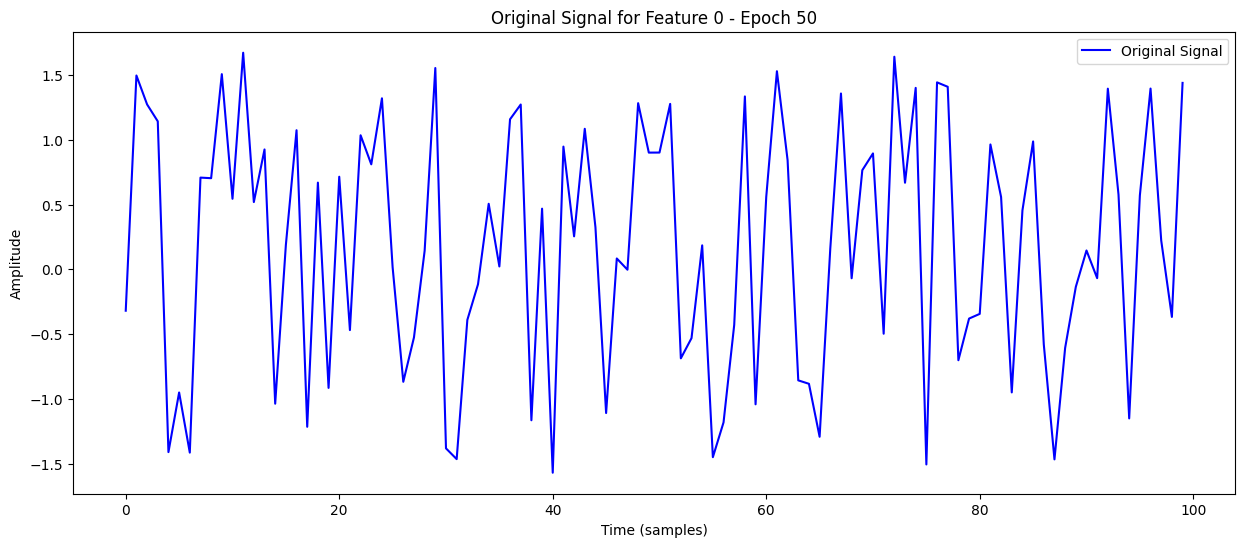

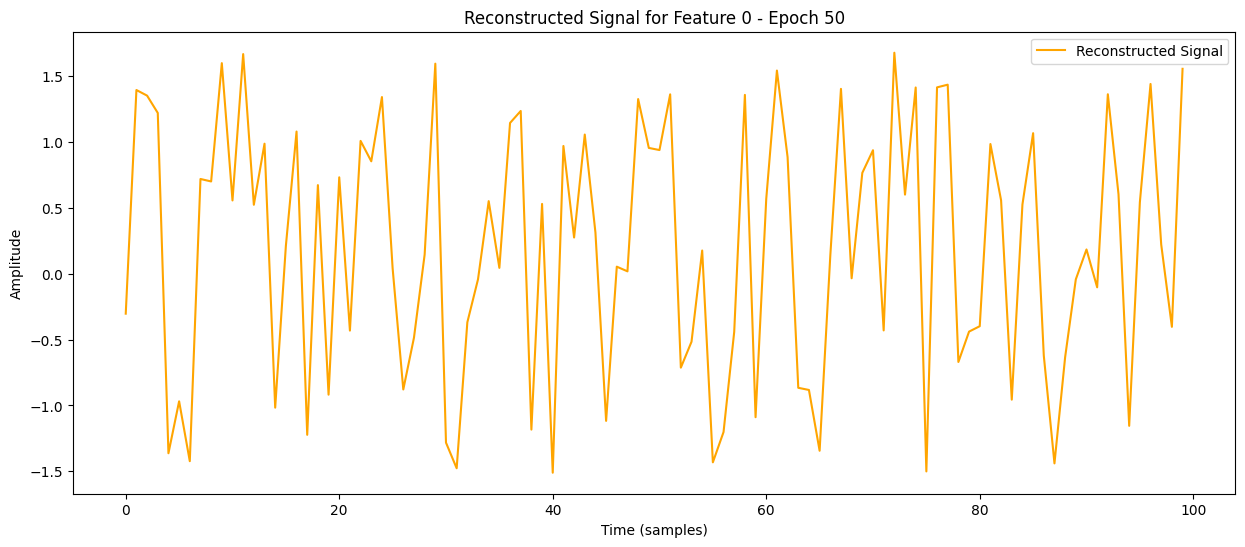

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


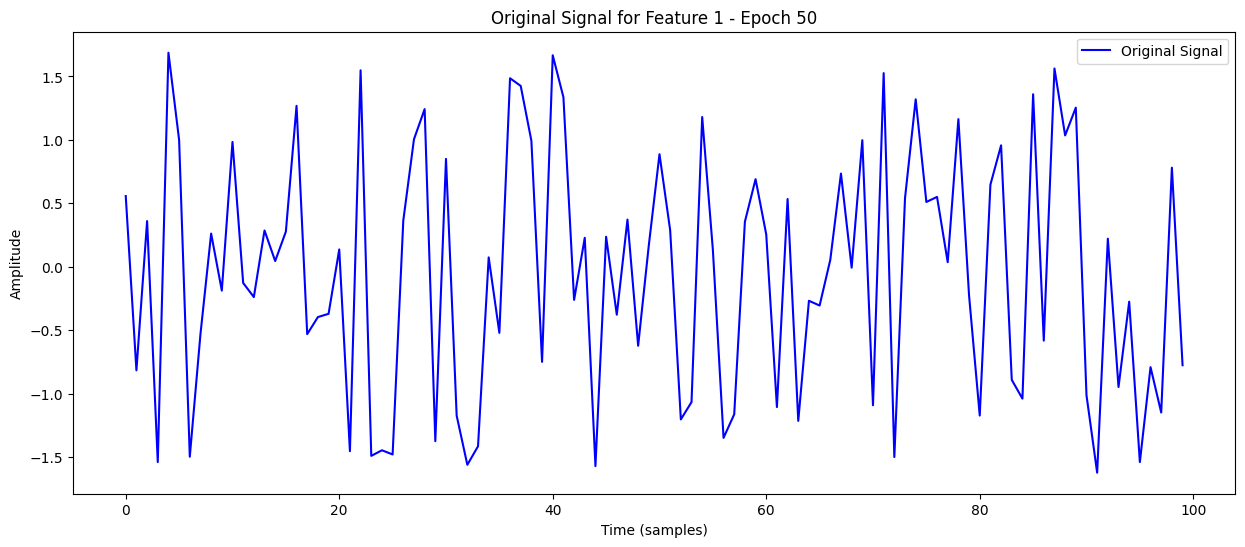

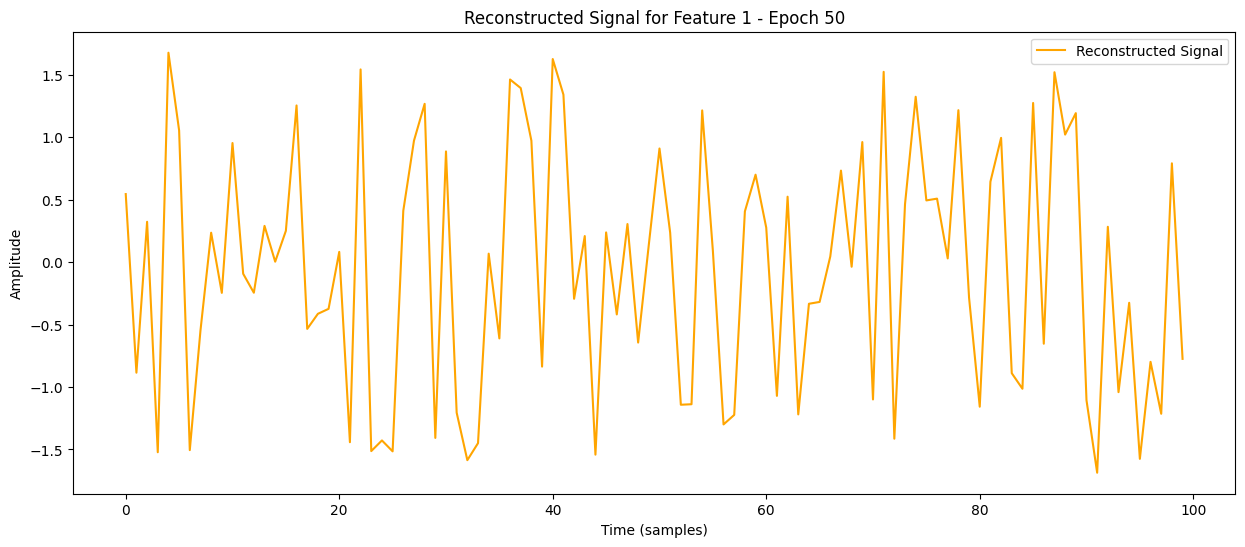

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


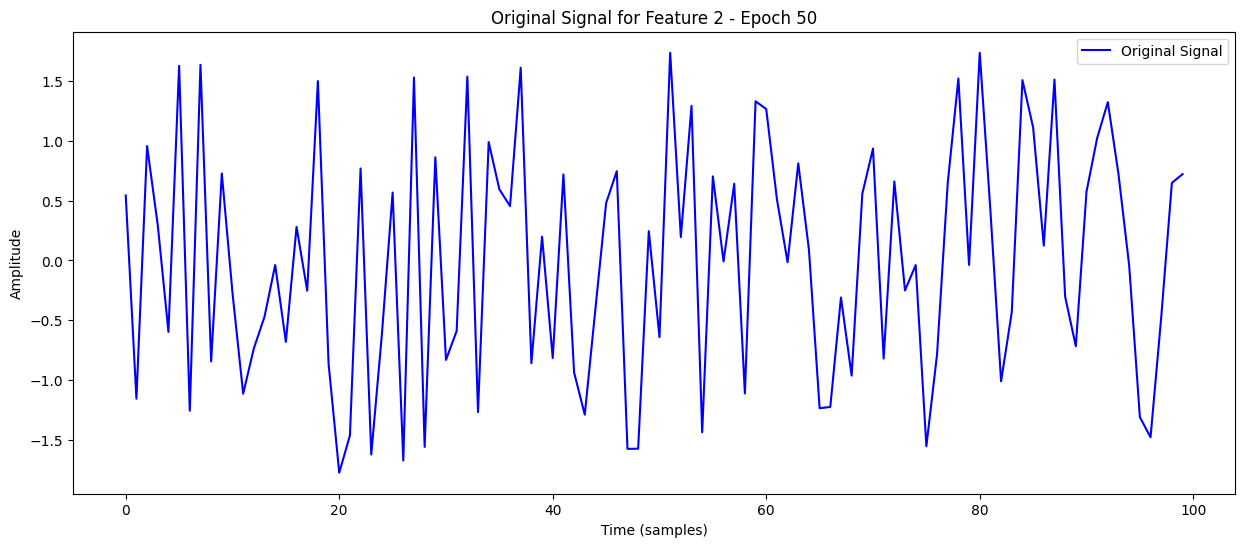

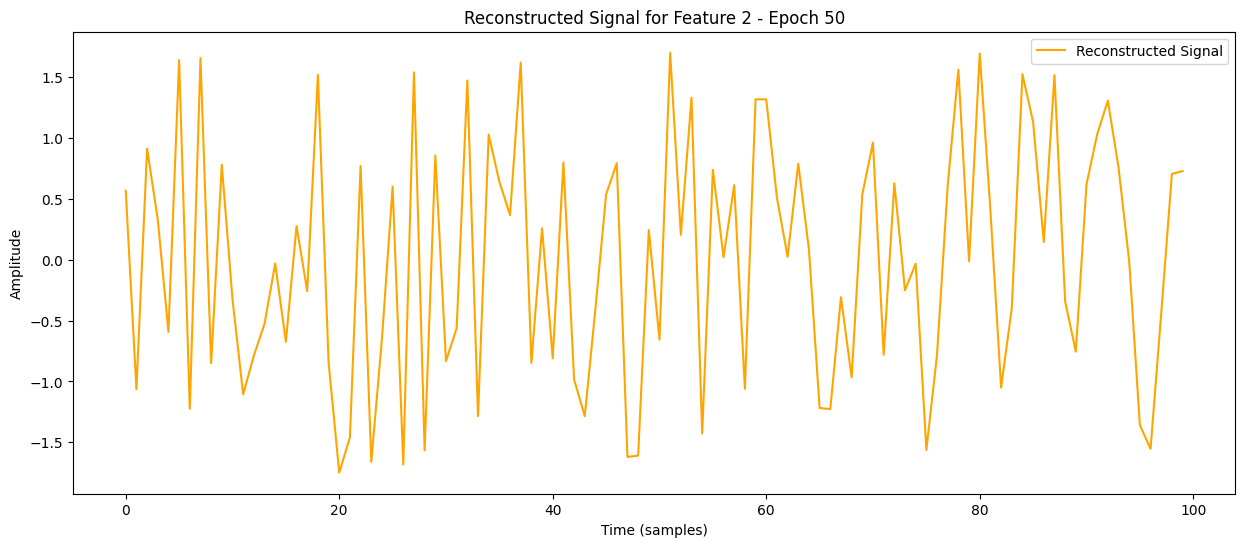

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


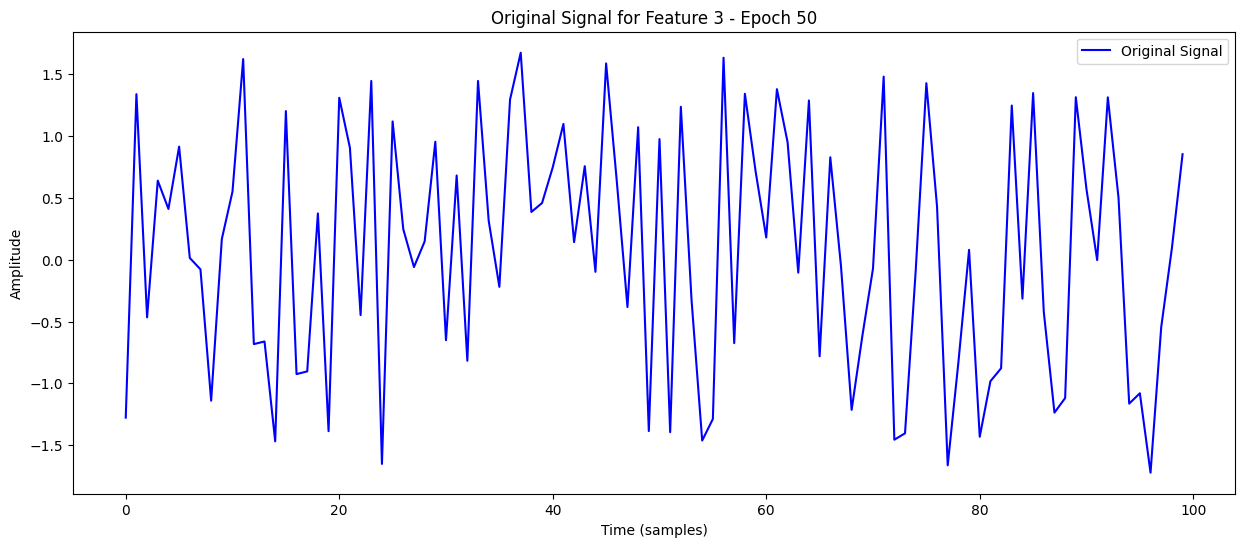

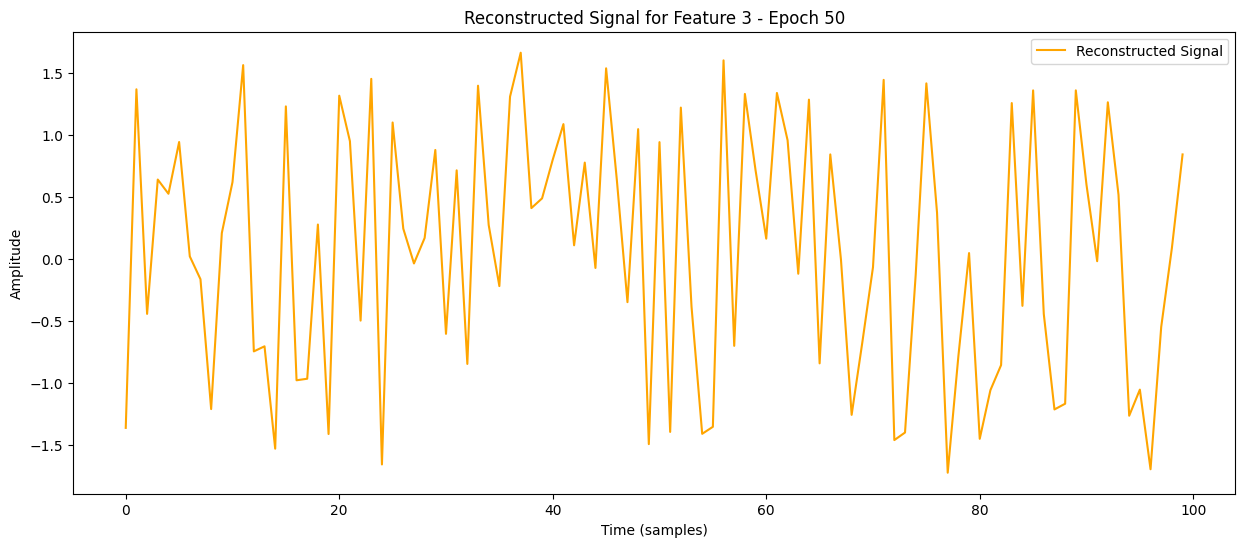

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


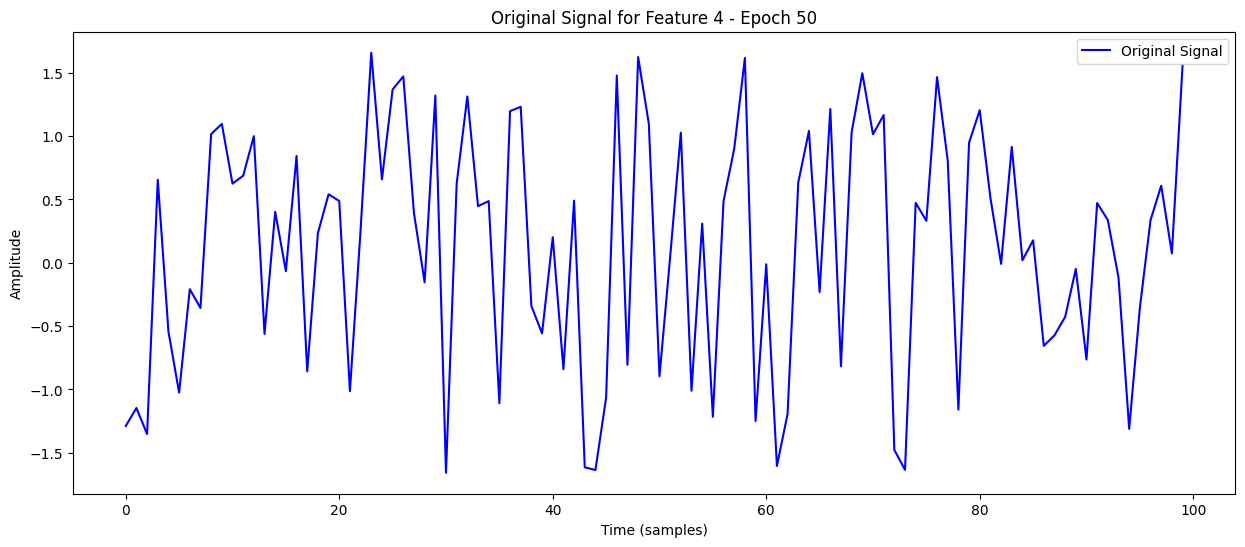

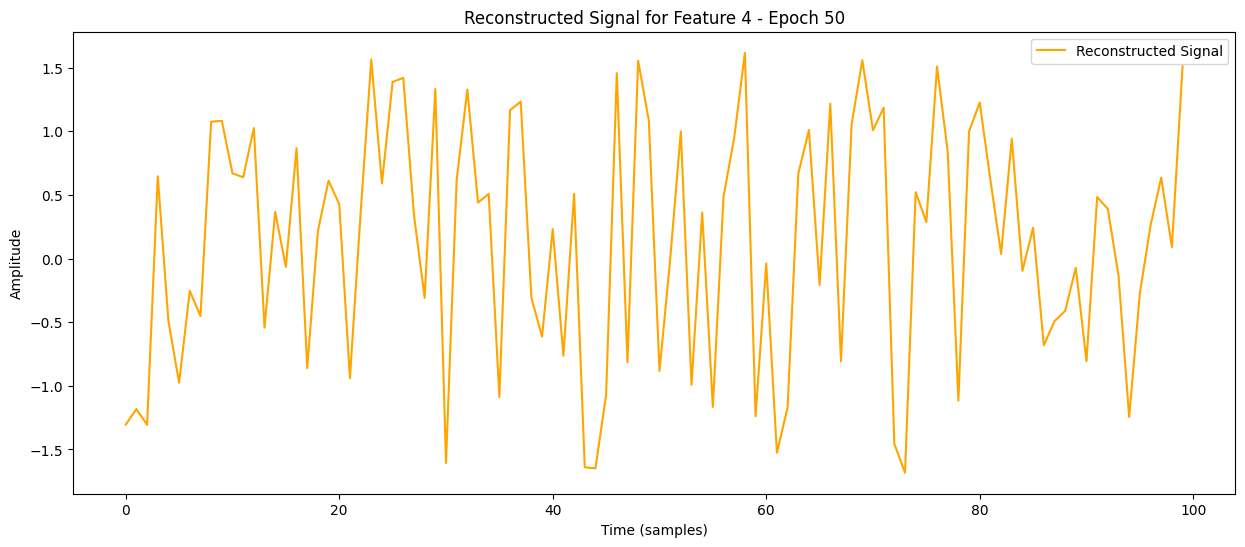

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf  # Import tensorflow if you are using Keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Example: Replace this with your actual DataFrame
# Ensure your DataFrame X is loaded with data
X = pd.DataFrame(np.random.rand(1000, 5), columns=[f"Feature_{i}" for i in range(5)])  # Example placeholder data

# Standardize the data
scaler = StandardScaler()

# Convert all columns of X to numeric, handling errors by coercing to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with the column mean (or median as an alternative)
for column in X.columns:
    if X[column].dropna().size > 0:  # Check if the column has valid (non-NaN) values
        X[column] = X[column].fillna(X[column].mean())  # Fill with column mean
    else:
        X[column] = X[column].fillna(0)  # If all values are NaN, fill with 0

# Check if the DataFrame is still empty
if X.empty:
    raise ValueError("DataFrame X is empty after handling NaN values. Check your data source.")
else:
    # Standardize the data
    X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test = train_test_split(X_scaled, test_size=0.3, random_state=42)

# Function to plot original and reconstructed signals in separate graphs
def plot_input_vs_reconstruction(autoencoder, X_test, epoch, sampling_rate=100, duration=1):
    samples_to_plot = sampling_rate * duration  # Number of samples for 1 second
    num_features = X_test.shape[1]  # Number of features (columns)

    for col_index in range(num_features):
        # Get the original and reconstructed signals
        original_signal = X_test[:samples_to_plot, col_index]
        reconstructed_signal = autoencoder.predict(X_test[:samples_to_plot])[:, col_index]

        # Plot the original signal
        plt.figure(figsize=(15, 6))
        plt.plot(range(samples_to_plot), original_signal, label='Original Signal', color='blue')
        col_name = f"Feature {col_index}"  # Replace with X.columns[col_index] if X is a DataFrame
        plt.title(f'Original Signal for {col_name} - Epoch {epoch}')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

        # Plot the reconstructed signal
        plt.figure(figsize=(15, 6))
        plt.plot(range(samples_to_plot), reconstructed_signal, label='Reconstructed Signal', color='orange')
        plt.title(f'Reconstructed Signal for {col_name} - Epoch {epoch}')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

# Define the autoencoder model using Keras (example)
autoencoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(X_train.shape[1], activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder (example)
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test))

# Plot for a specific epoch (e.g., the last epoch after training)
plot_input_vs_reconstruction(autoencoder, X_test, epoch=50, sampling_rate=100, duration=1)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3845/3845 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1232 - val_loss: 0.0060
Epoch 2/50
3845/3845 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0054 - val_loss: 0.0017
Epoch 3/50
3845/3845 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 4/50
3845/3845 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 5/50
3845/3845 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0011 - val_loss: 3.2169e-04
Epoch 6/50
3845/3845 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 6.8860e-04 - val_loss: 0.0018
Epoch 7/50
3845/3845 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.4743e-04 - val_loss: 2.6955e-04
Epoch 8/50
3845/3845 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 6.3708e-04 - val_loss: 1.3162e-04
Epoch 9/50
3845/3845 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 5.8597e-04 - val_loss: 4.3327e-04
Epoch 10/50
3845/3845 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 5.3057e-04 - val_loss: 1.6981e-04
Epoch 11/50
3845/3845 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 6.8891e-04 - val_lo

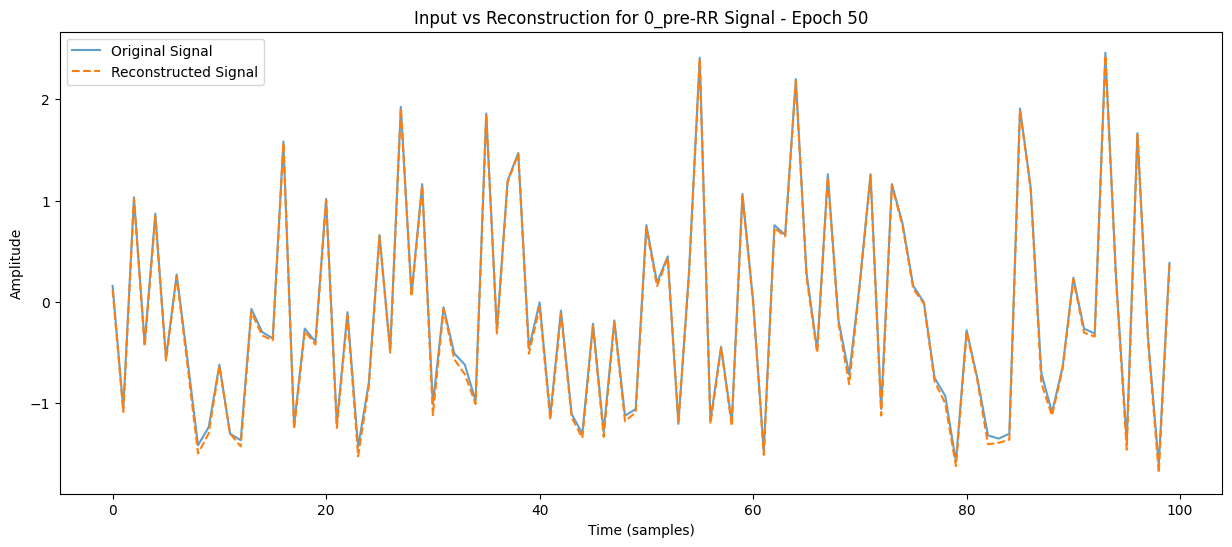

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


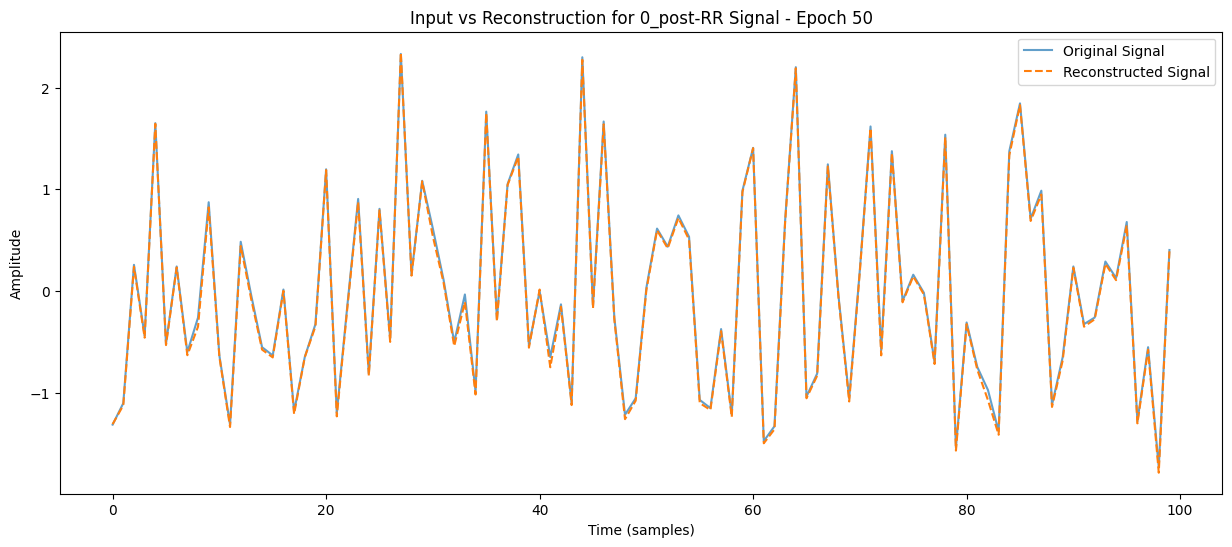

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


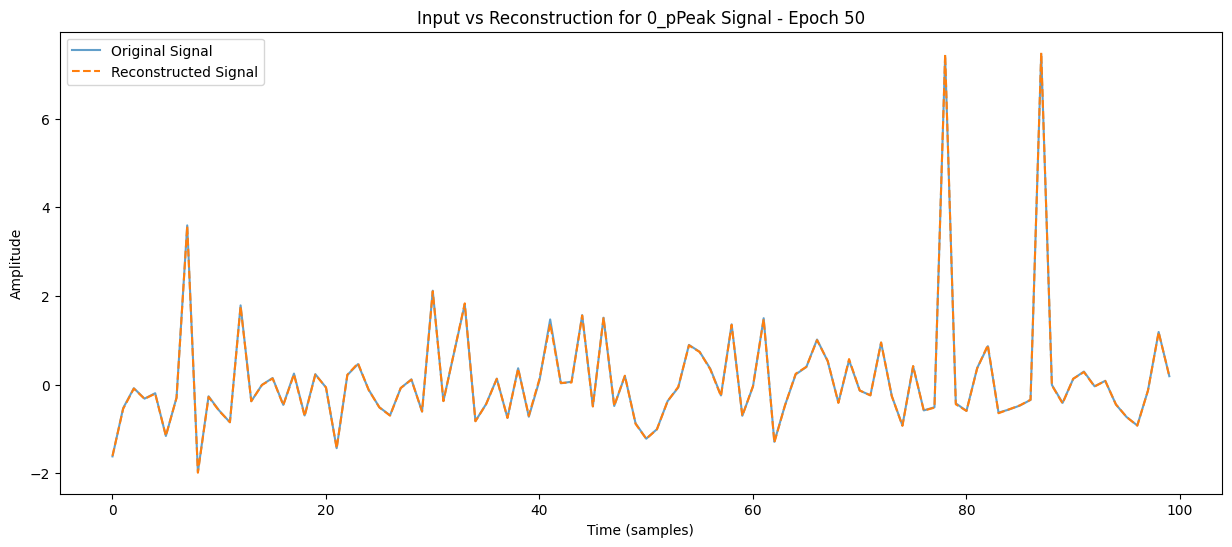

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


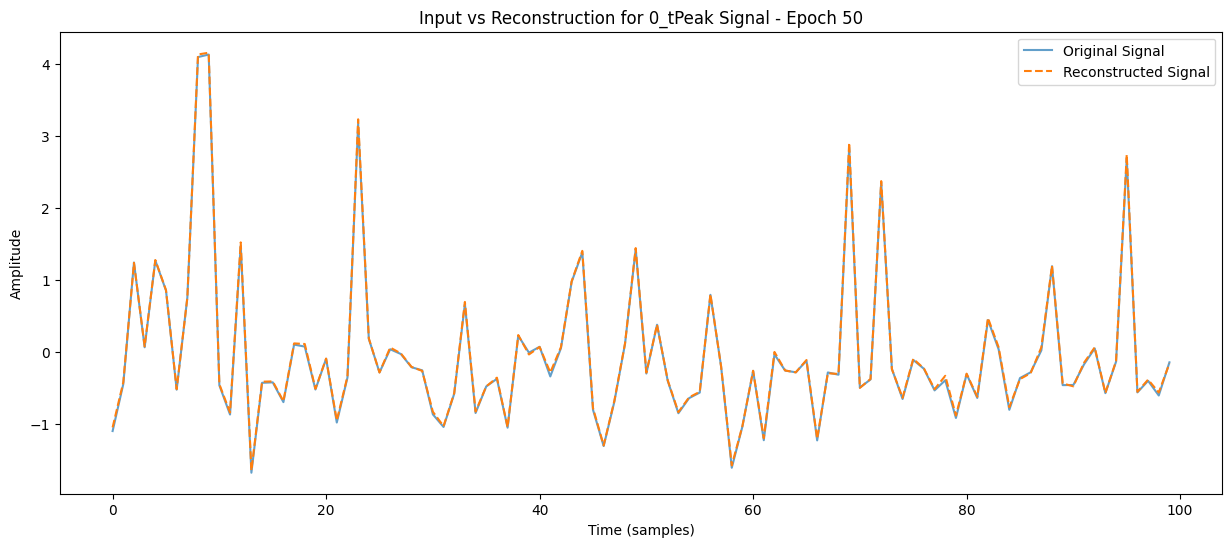

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


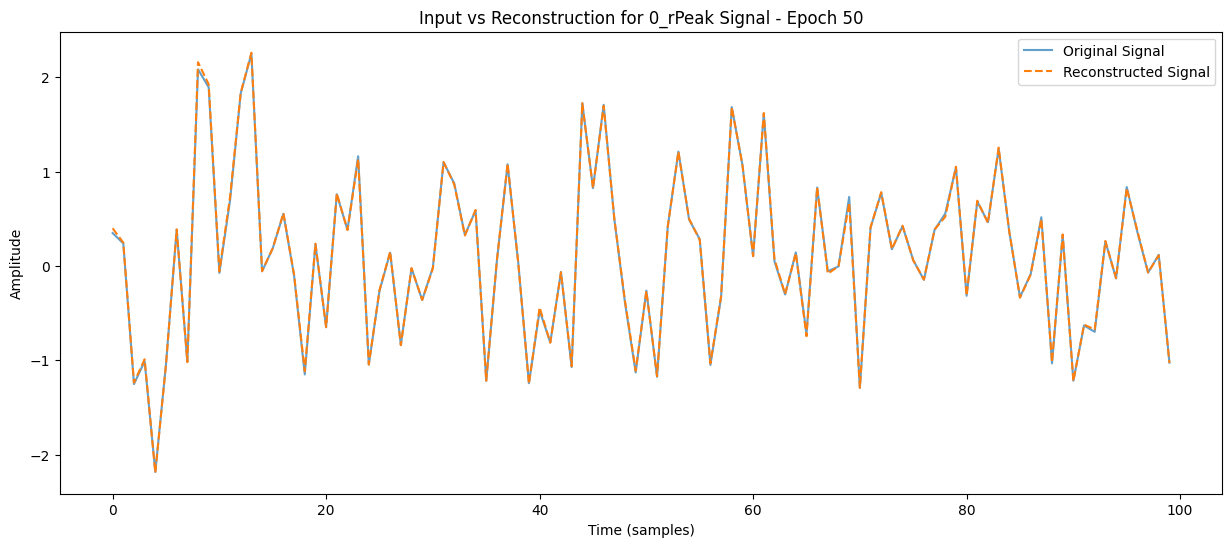

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


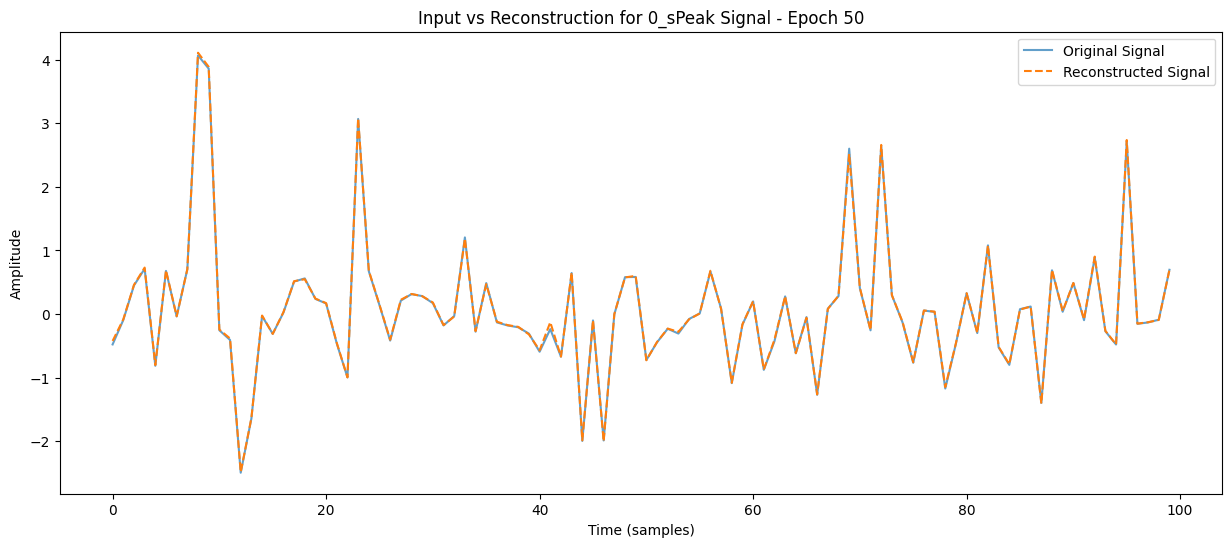

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


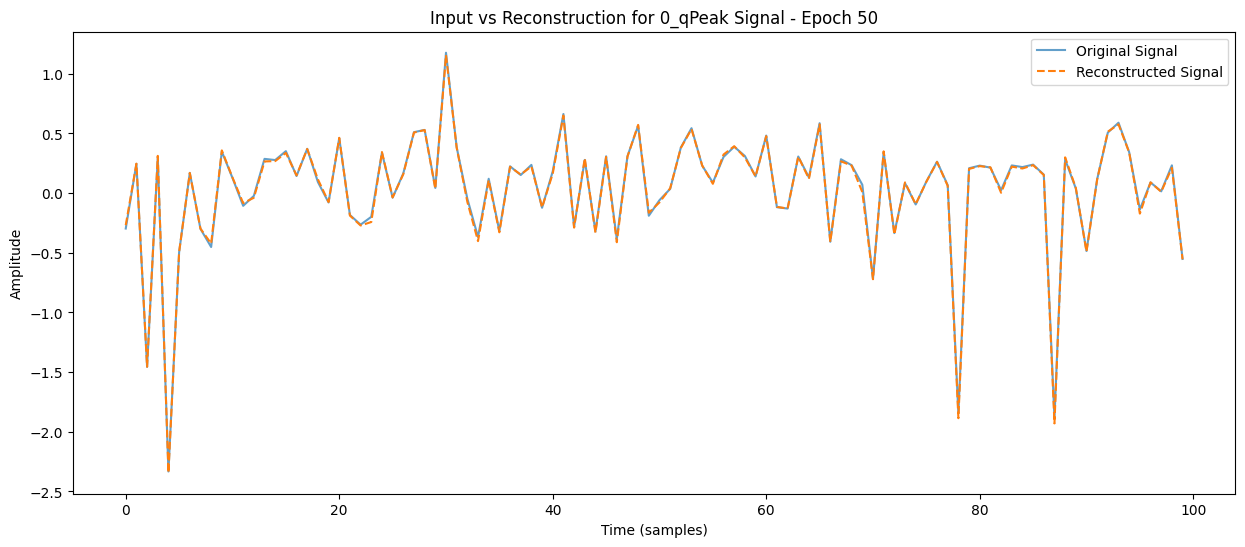

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


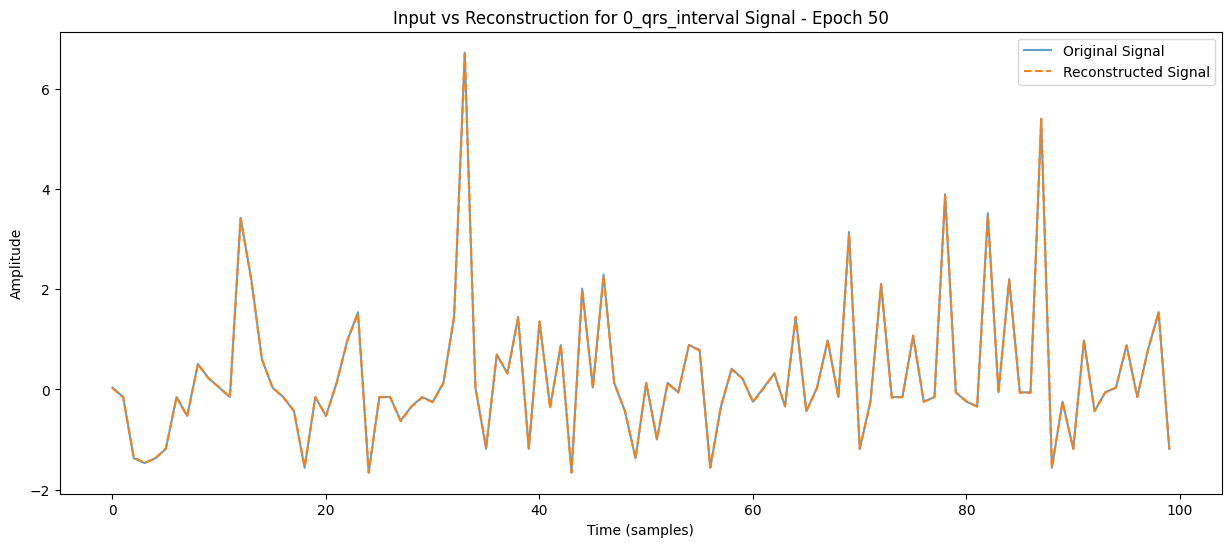

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


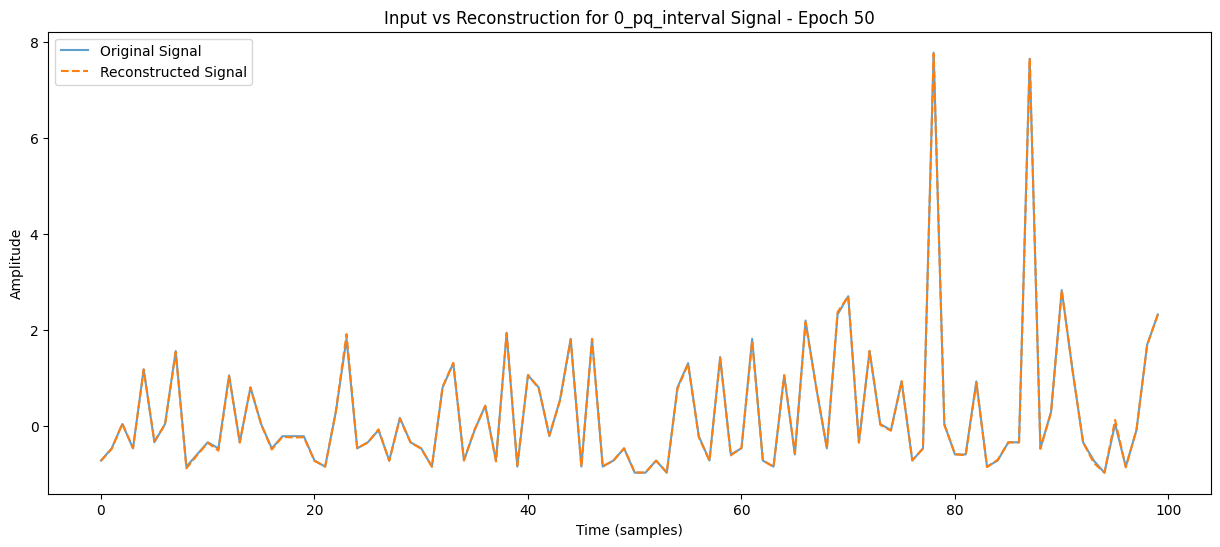

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


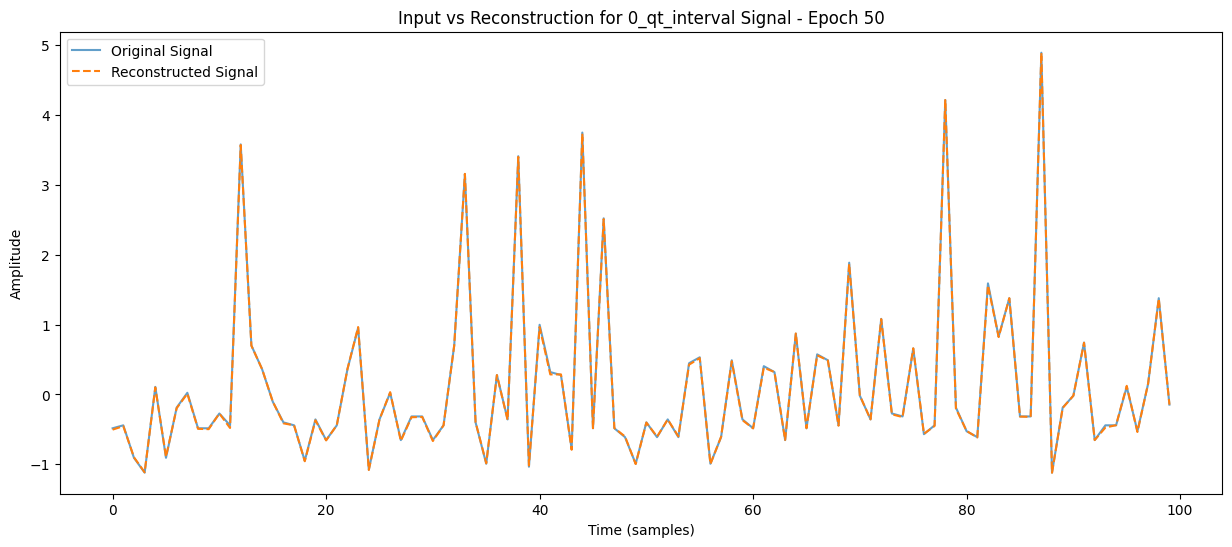

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


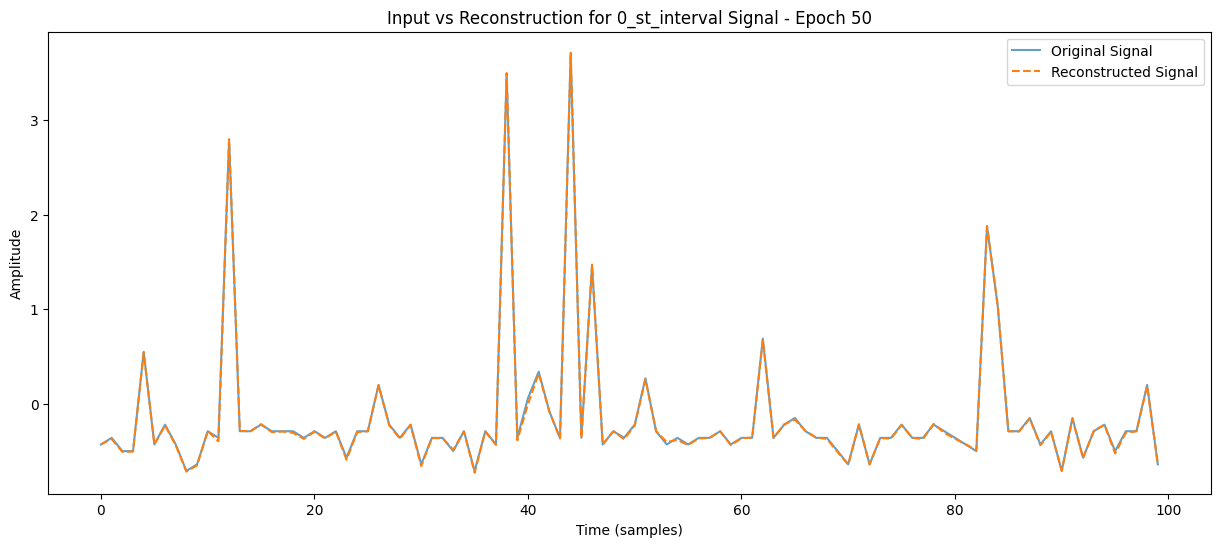

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


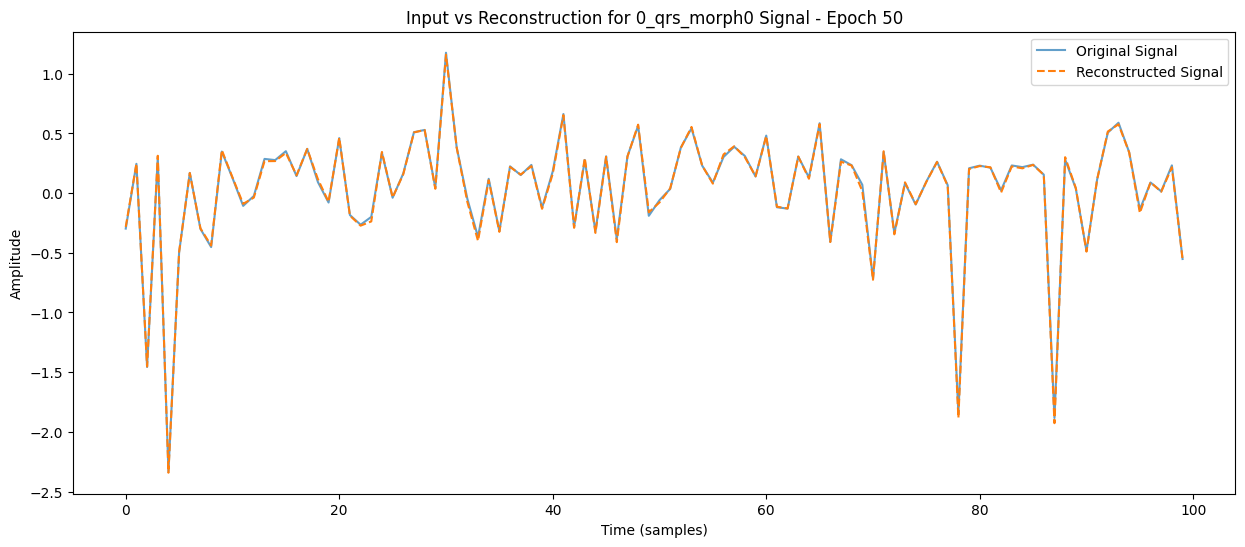

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


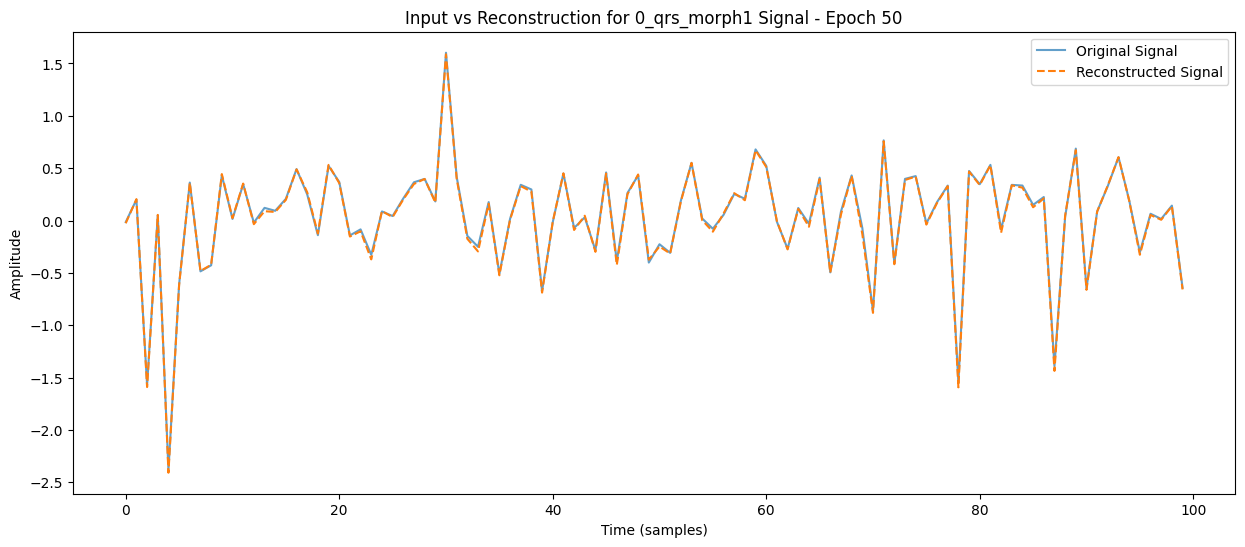

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


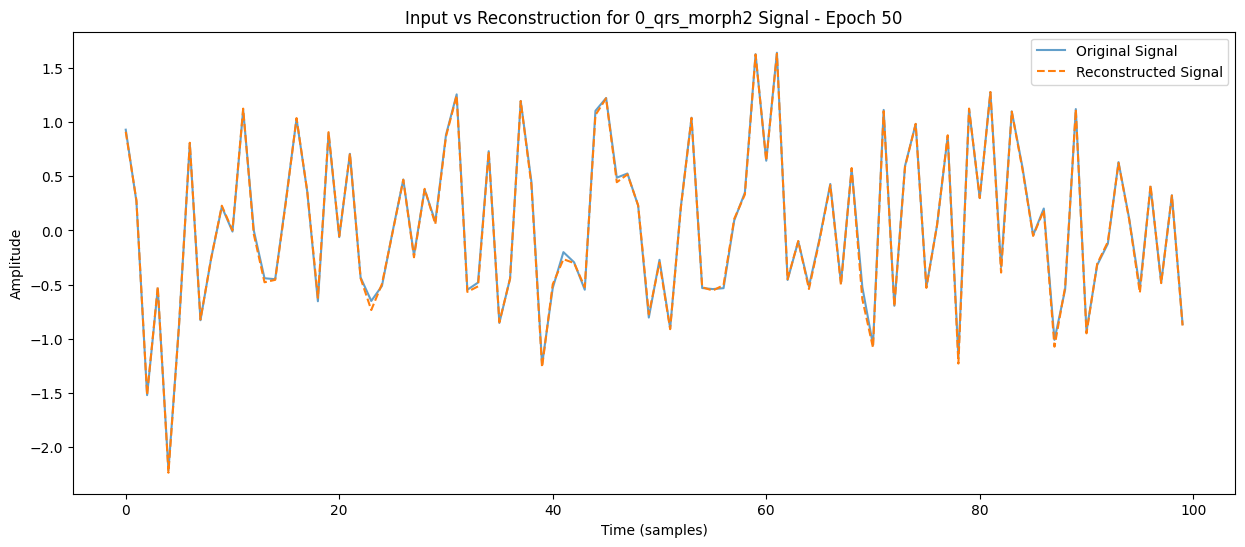

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


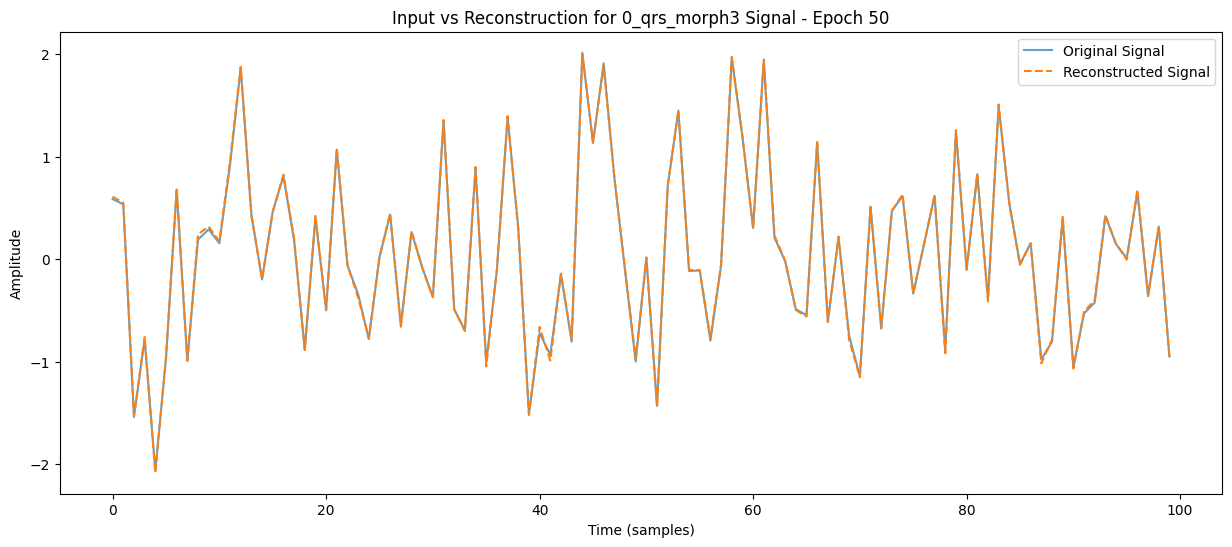

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


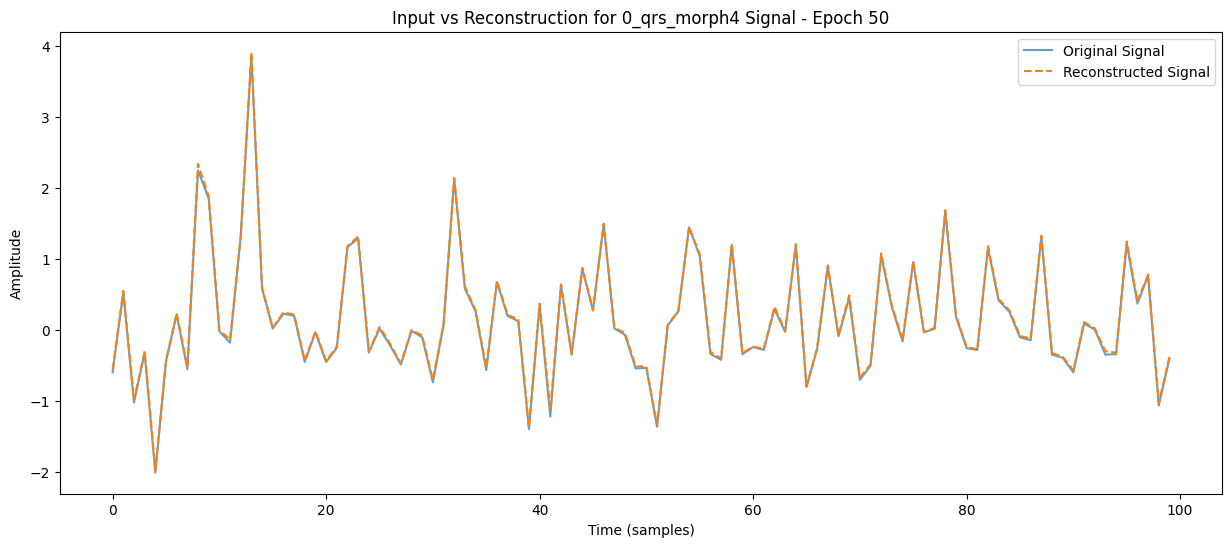

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


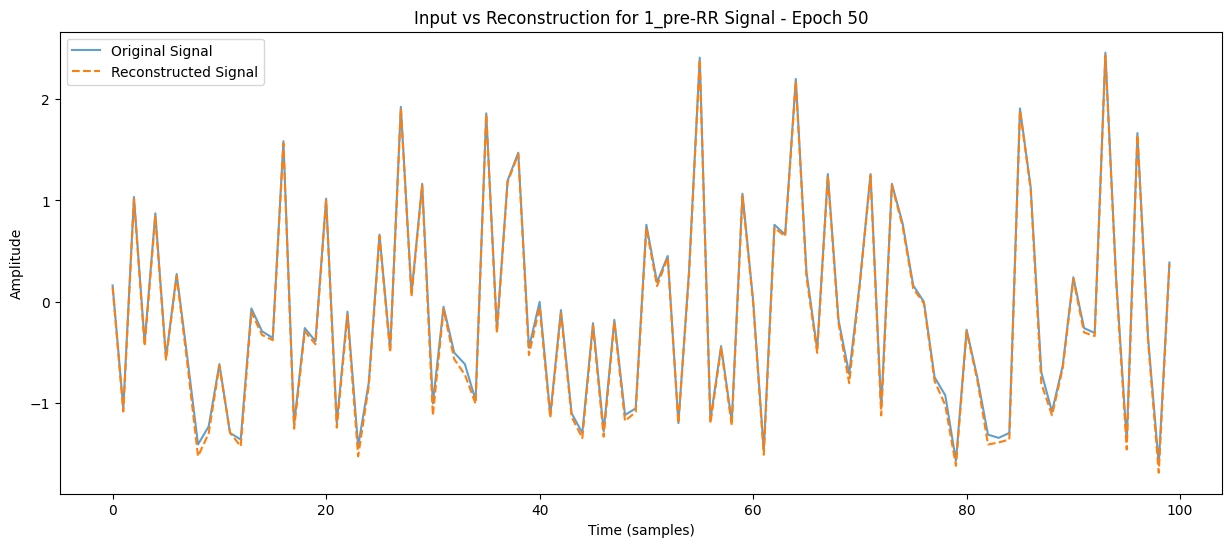

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


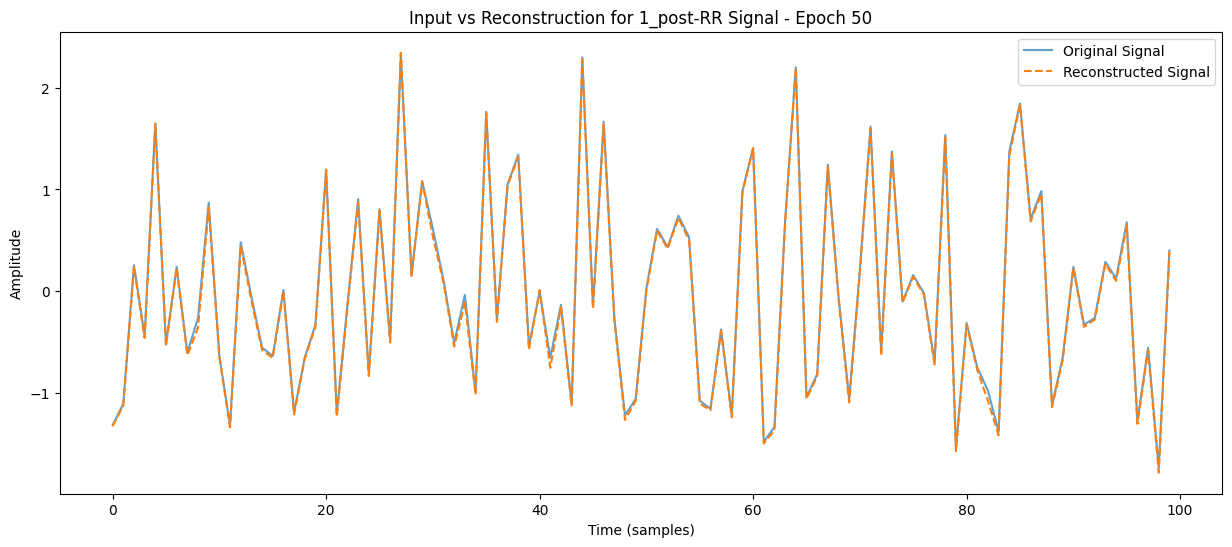

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


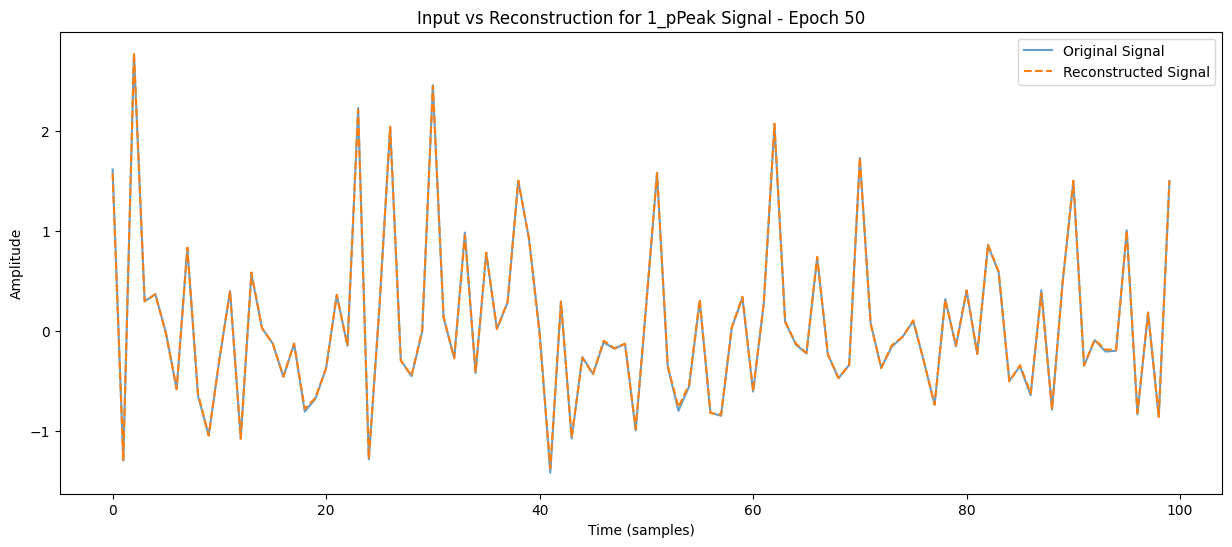

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


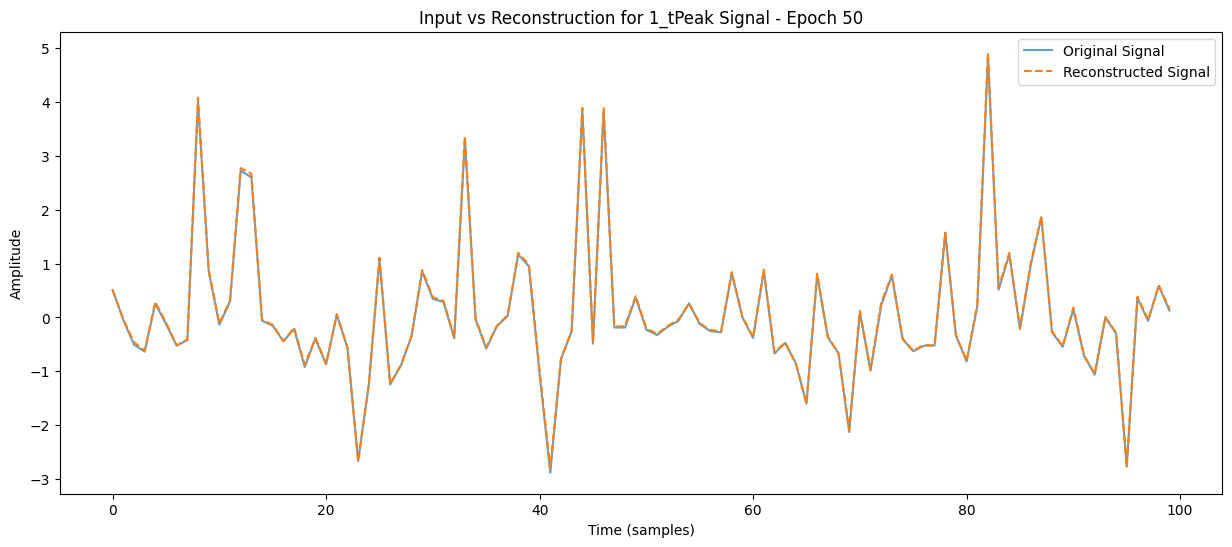

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


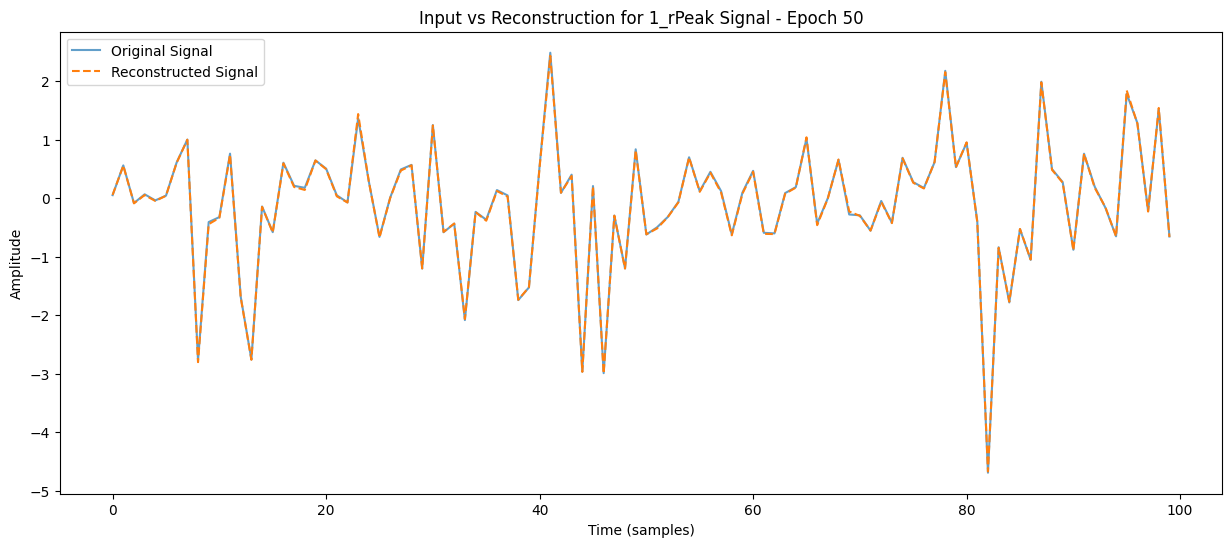

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


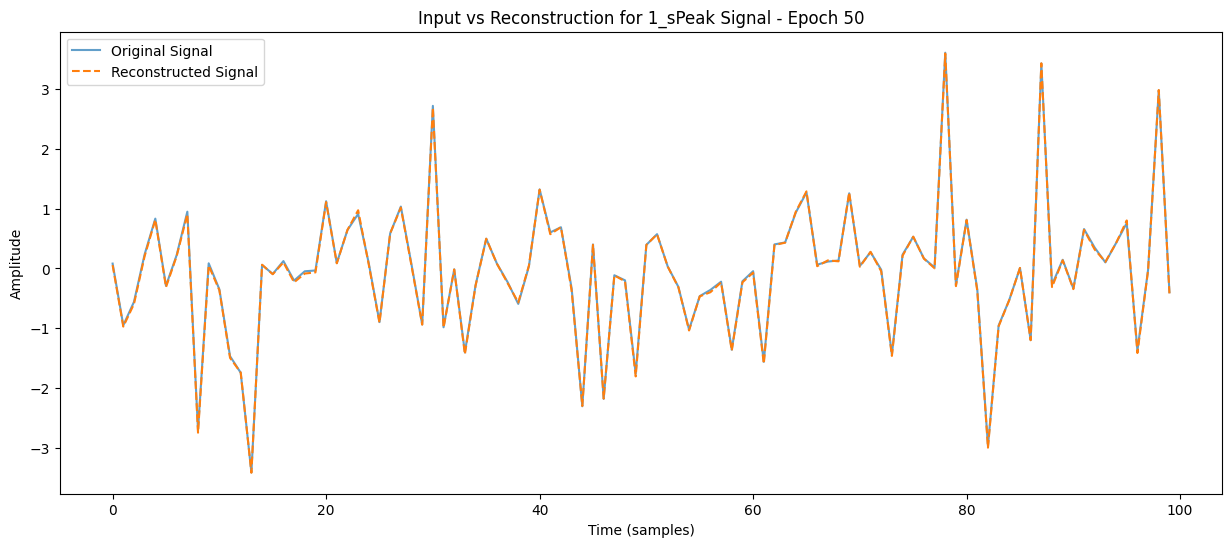

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


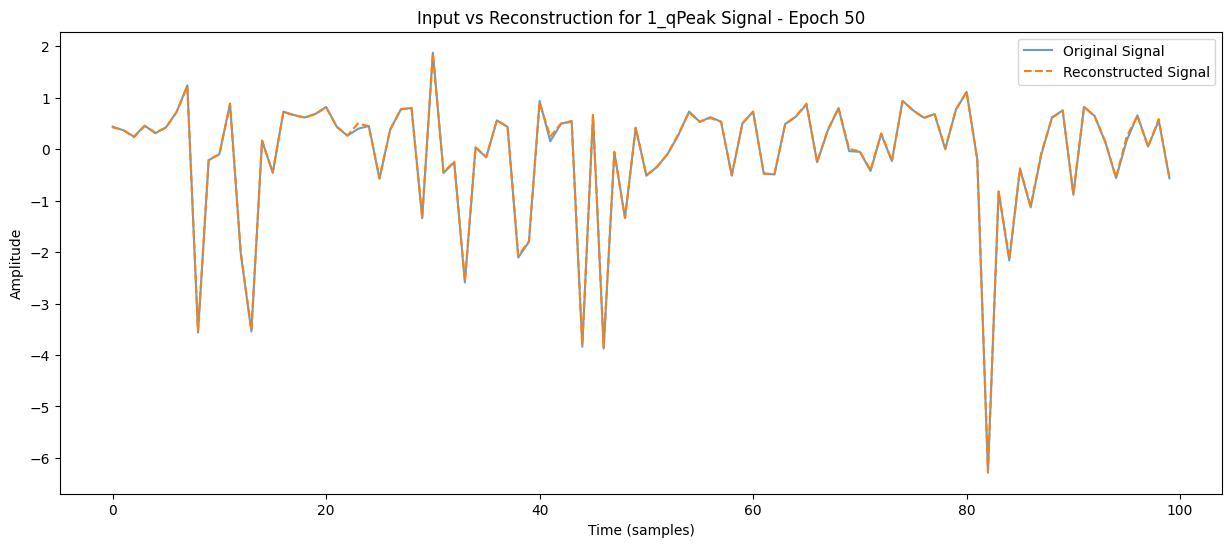

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


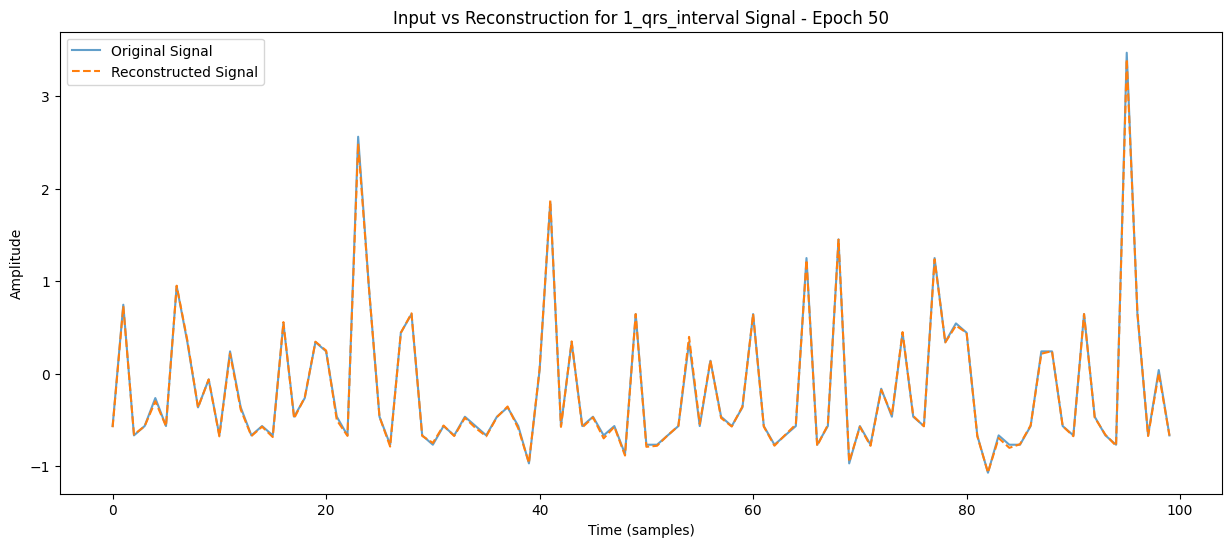

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


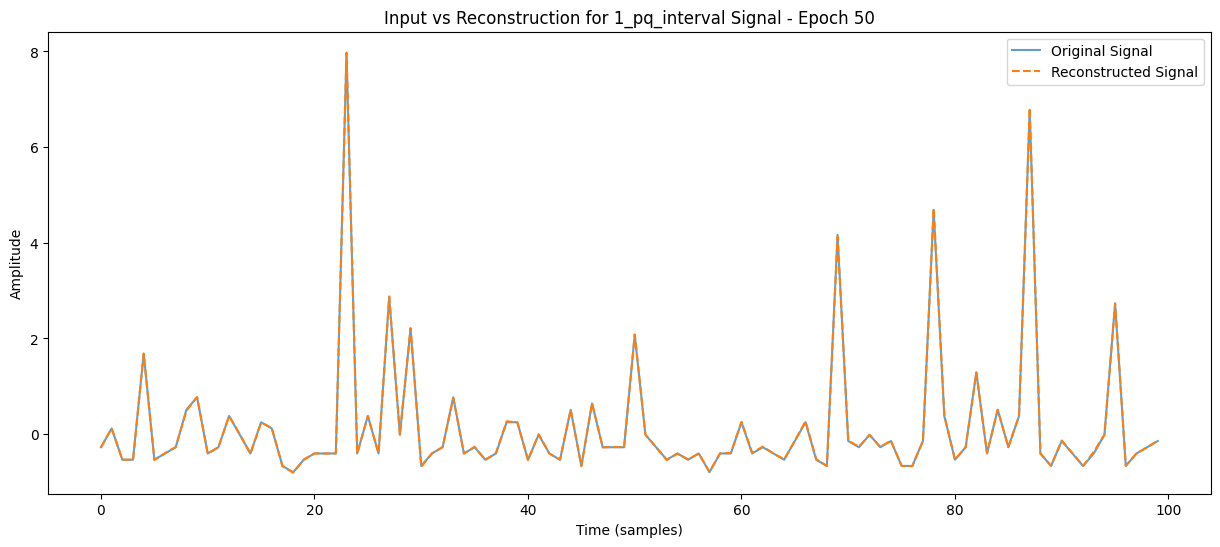

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


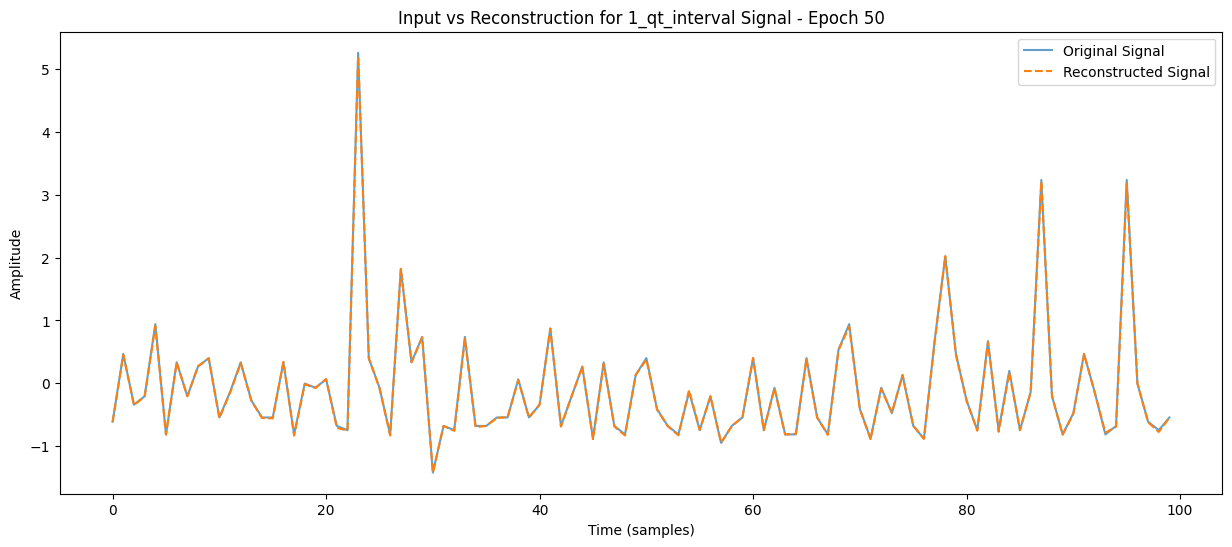

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


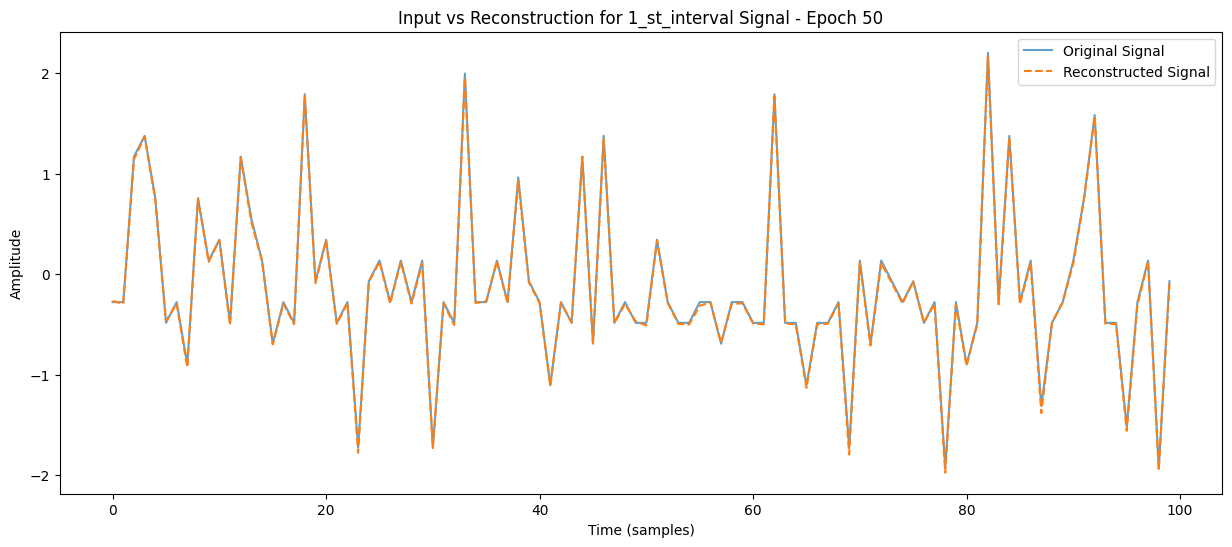

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


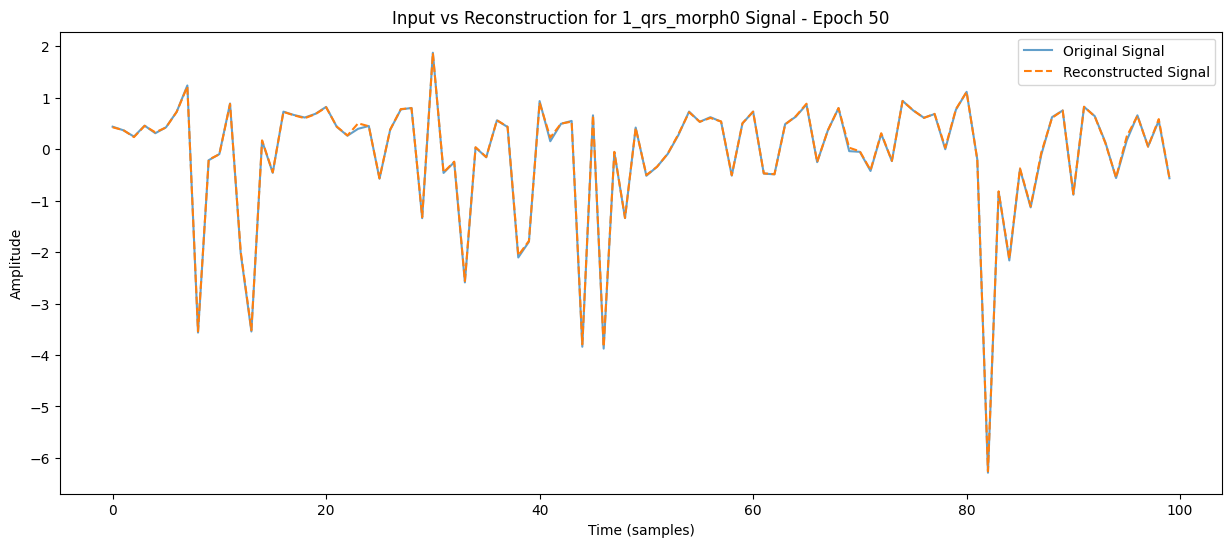

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


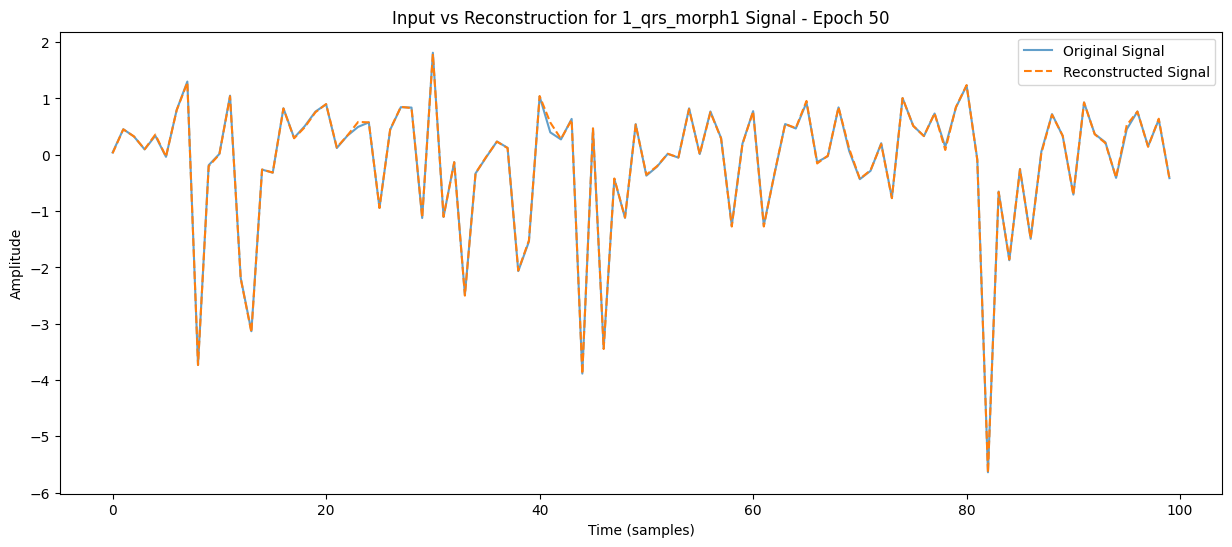

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


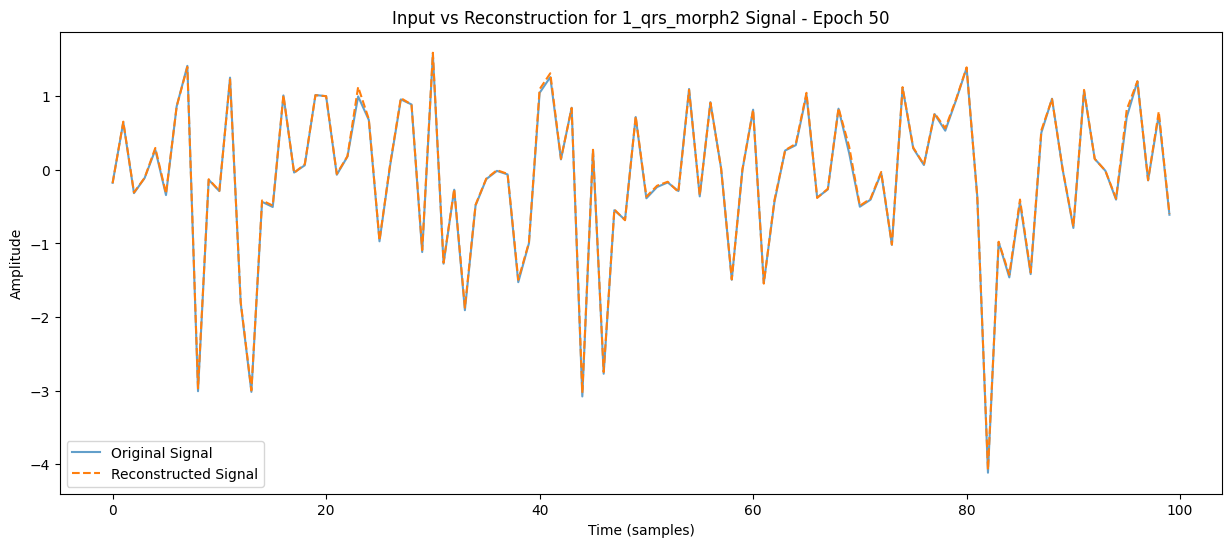

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


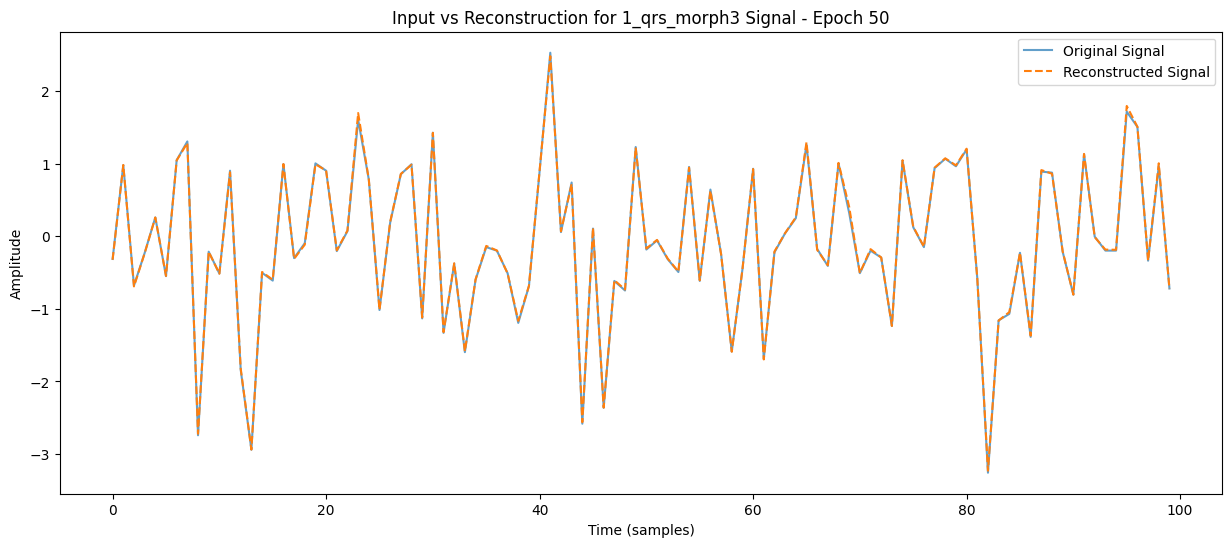

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


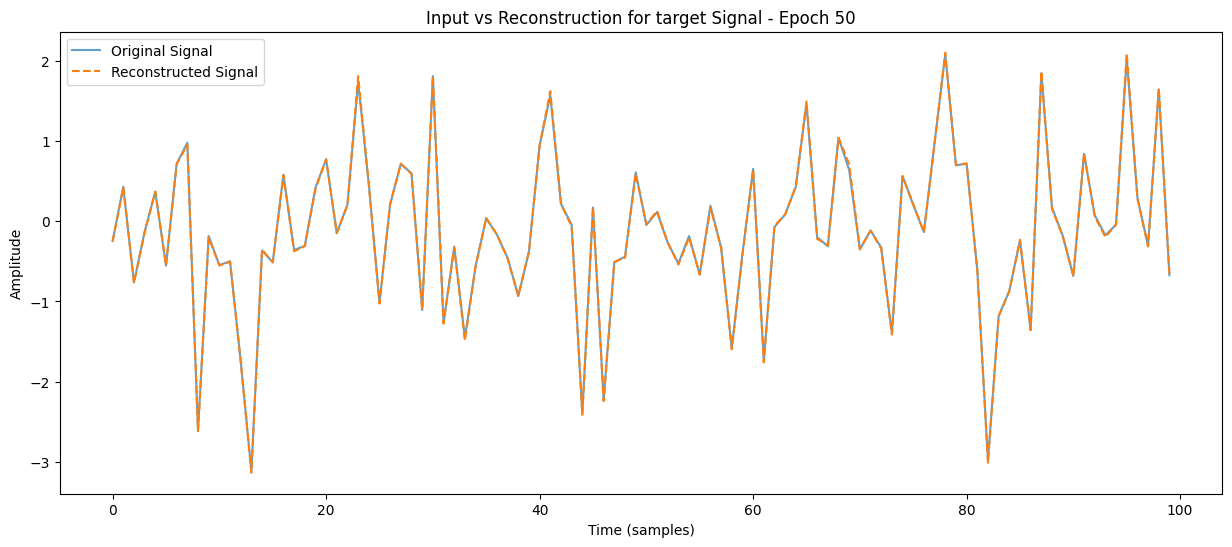

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf # Import tensorflow if you are using Keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


# Standardize the data
scaler = StandardScaler()

# Convert all columns of X to numeric, handling errors by coercing to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with the column mean (or median as an alternative)
for column in X.columns:
    if X[column].dropna().size > 0:  # Check if the column has valid (non-NaN) values
        X[column] = X[column].fillna(X[column].mean())  # Fill with column mean
    else:
        X[column] = X[column].fillna(0)  # If all values are NaN, fill with 0

# Check if the DataFrame is still empty
if X.empty:
    raise ValueError("DataFrame X is empty after handling NaN values. Check your data source.")
else:
    # Standardize the data
    X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test = train_test_split(X_scaled, test_size=0.3, random_state=42)


def plot_input_vs_reconstruction(autoencoder, X_test, epoch, sampling_rate=100, duration=1):
    samples_to_plot = sampling_rate * duration  # Number of samples for 1 second
    # Get the number of features (columns) from X_test
    num_features = X_test.shape[1]

    # Update the loop to use the correct number of features
    for col_index in range(num_features):
        # Get the original and reconstructed signals
        original_signal = X_test[:samples_to_plot, col_index]
        reconstructed_signal = autoencoder.predict(X_test[:samples_to_plot])[:, col_index]

        # Plot input vs reconstruction
        plt.figure(figsize=(15, 6))
        plt.plot(range(samples_to_plot), original_signal, label='Original Signal', alpha=0.7)
        plt.plot(range(samples_to_plot), reconstructed_signal, label='Reconstructed Signal', linestyle='dashed')
        # Get the column name from the DataFrame using the column index (assuming X was created from a DataFrame)
        col_name = X.columns[col_index]  # Replace 'X' with the original DataFrame variable if needed
        plt.title(f'Input vs Reconstruction for {col_name} Signal - Epoch {epoch}')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

# Define the autoencoder model using Keras (example)
autoencoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(X_train.shape[1], activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder (example)
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test))

# Plot for a specific epoch (e.g., the last epoch after training)
plot_input_vs_reconstruction(autoencoder, X_test, epoch=50, sampling_rate=100, duration=1)

In [ ]:
# Define features (X) and target (y)
X = df[ecg_columns]
y = df[target_column]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert all columns of X_train and X_test to numeric, handling errors
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Impute NaN values using SimpleImputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Or use 'median'
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Assuming you want to create 3 classes based on the distribution of the target variable
y_train = pd.cut(y_train, bins=3, labels=False)
y_test = pd.cut(y_test, bins=3, labels=False)

# Train KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predictions and evaluation
y_pred = knn.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['record' 'type']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['record' 'type']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1 Score: 0.97


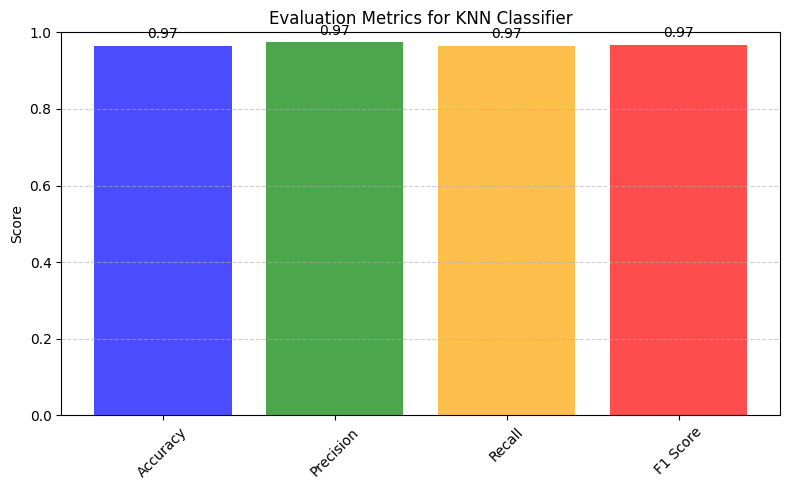

In [ ]:
# Visualization: Bar Chart of Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
plt.ylim(0, 1)  # Since metric values are between 0 and 1
plt.ylabel('Score')
plt.title('Evaluation Metrics for KNN Classifier')
plt.xticks(rotation=45)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10, color='black')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


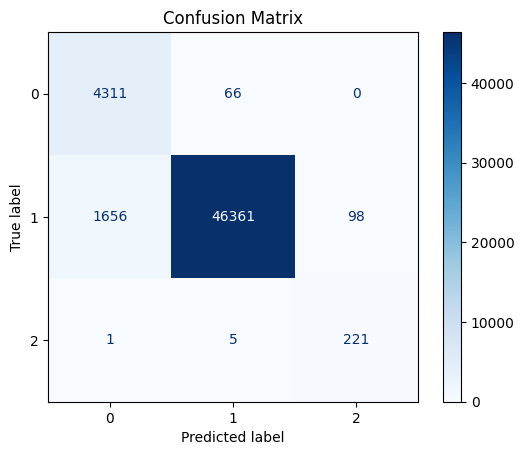

In [ ]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

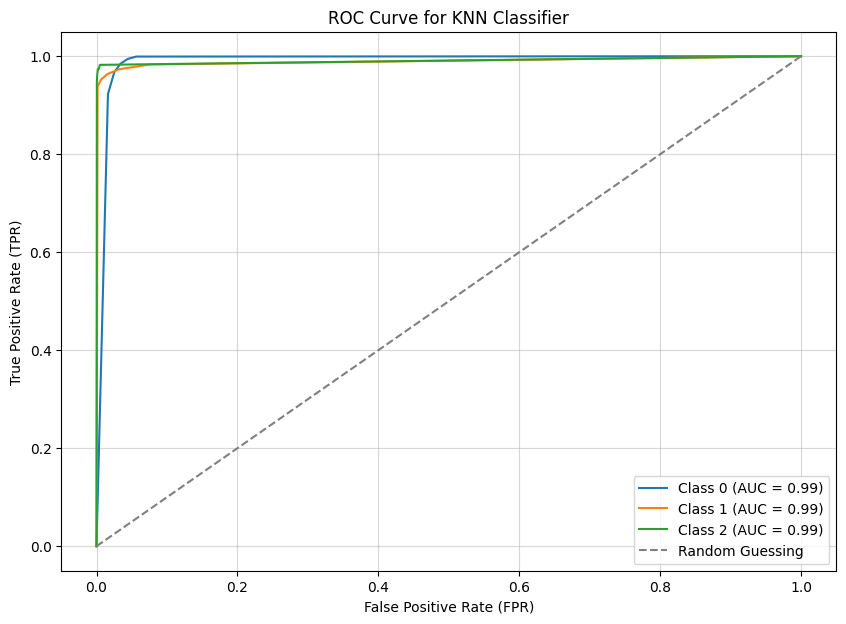

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf # Import tensorflow if you are using Keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize # Import label_binarize
import pandas as pd
import numpy as np # Import numpy with alias np


# ... (Rest of the code)

# Binarize the target values for multiclass classification
# Assuming there are 3 classes (0, 1, 2)
n_classes = len(np.unique(y_train))
y_test_binarized = label_binarize(y_test, classes=range(n_classes))
y_pred_proba = knn.predict_proba(X_test)  # Predict probabilities

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], color="grey", linestyle="--", label="Random Guessing")

# Configure the plot
plt.title("ROC Curve for KNN Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()
